# Projet MCS :  Détection d'activité humaine - DTW et classification avec réduction de dimension

Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale) et l'accélération estimée du corps. 
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : DTW et application du TD
- Partie II : Système de reconnaissance d'activité physique avec la DTW
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données par ACP
- Partie IV : Votre étude


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [2]:
# Paramètres du dataset
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = 'WISDM_ar_v1.1_raw.txt'

## 1. Chargement des données d'apprentissage et de test

In [3]:
# LOAD DATA
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()
print(data.shape)

(1098203, 6)


In [4]:
data

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.69
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.73
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.69
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.73


<AxesSubplot:>

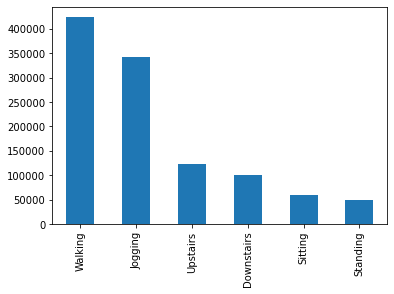

In [5]:
plt.rcParams["figure.figsize"] = (6,4)
fig, ax = plt.subplots()

data['activity'].value_counts().plot(ax=ax, kind='bar')

In [6]:
data.groupby('activity').count()

,user,timestamp,x-axis,y-axis,z-axis
activity,,,,,
Downstairs,100427,100427,100427,100427,100427
Jogging,342176,342176,342176,342176,342176
Sitting,59939,59939,59939,59939,59939
Standing,48395,48395,48395,48395,48395
Upstairs,122869,122869,122869,122869,122869
Walking,424397,424397,424397,424397,424397


In [7]:
#Setting base parameters
TIME_STEP = 60
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=30
TAILLE_APP=10
profil_moyen=[]
List_Data_Test=[]
Data_Test=[]
Data_App=[]
Label_Test=[]
Label_App=[]

In [8]:
def get_data_convoluted(our_labels=LABELS, seg_time_size =SEGMENT_TIME_SIZE, time_step=TIME_STEP , number_of_classes=N_CLASSES):
  # DATA PREPROCESSING
  data_convoluted = []
  labels = []

  # Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
  for j in range(0,number_of_classes):
      DataBest = data[data['activity'] == our_labels[j]]
      for i in range(0, len(DataBest) - seg_time_size, time_step):
          x = DataBest['x-axis'].values[i: i + seg_time_size]
          y = DataBest['y-axis'].values[i: i + seg_time_size]
          z = DataBest['z-axis'].values[i: i + seg_time_size]
          data_convoluted.append([x, y, z])
      # Label for a data window is the label that appears most commonly
          label = j
          labels.append(label)

  # Convert to numpy
  data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

  # One-hot encoding
  labels = np.asarray(labels, dtype=np.int)
  print("Convoluted data shape: ", data_convoluted.shape)
  print("Labels shape:", labels.shape)
  # Plot activity curves
  print(data_convoluted.shape)

  return data_convoluted,labels

### Getting our convoluted data and lables

In [9]:
def spliting_data_Test_App(num_of_classes=N_CLASSES, seg_size=SEGMENT_TIME_SIZE,size_test=TAILLE_TEST, size_app=TAILLE_APP ,List_test_Data =List_Data_Test ):
  fig, axs = plt.subplots(num_of_classes,figsize=(30,30))
  fig.suptitle('Profil moyen Activité')
  
  for i in range(num_of_classes):
      # Selection des données correspondant à la classe i
      print('Classe N°',i)
      res=np.where(labels==i)
      res=np.array(res)
      res=np.ravel(res)
      taille=res.shape[0]

      # Création de la base de TestN_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
      tirage=np.random.randint(0,taille,size_test)
      List_test_Data[i*size_test:(i+1)*size_test]=res[tirage[0:size_test]]
      Label_Test[i*size_test:(i+1)*size_test]=i
      tir_dataTest=data_convoluted[res[tirage[0:size_test]],:,:]
      Data_Test[i*size_test:(i+1)*size_test,:]=np.reshape(tir_dataTest,(size_test,seg_size*N_FEATURES))
      # Création de la base d'Apprentissage
      tirage1=np.random.randint(0,taille,size_app)
      tir_dataApp=data_convoluted[res[tirage1[0:size_app]],:,:]
      Data_App[i*size_app:(i+1)*size_app,:]=np.reshape(tir_dataApp,(size_app,seg_size*N_FEATURES))
      Label_App[i*size_app:(i+1)*size_app]=i


      # Affichage du profil temporel moyen de la classe
      class1=np.median(tir_dataApp,axis=0)
      profil_moyen[i,:,:]=class1
              
      axs[i].plot(range(seg_size),class1[:,0],'b--')
      axs[i].plot(range(seg_size),class1[:,1],'r-')
      axs[i].plot(range(seg_size),class1[:,2],'k.')
      axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
      axs[i].set_title(LABELS[i], fontsize=20)

  print(Data_App.shape)
  print(Data_Test.shape)


### Cas I: Parametres de Base (3 Classes)

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(30, 90)
(90, 90)


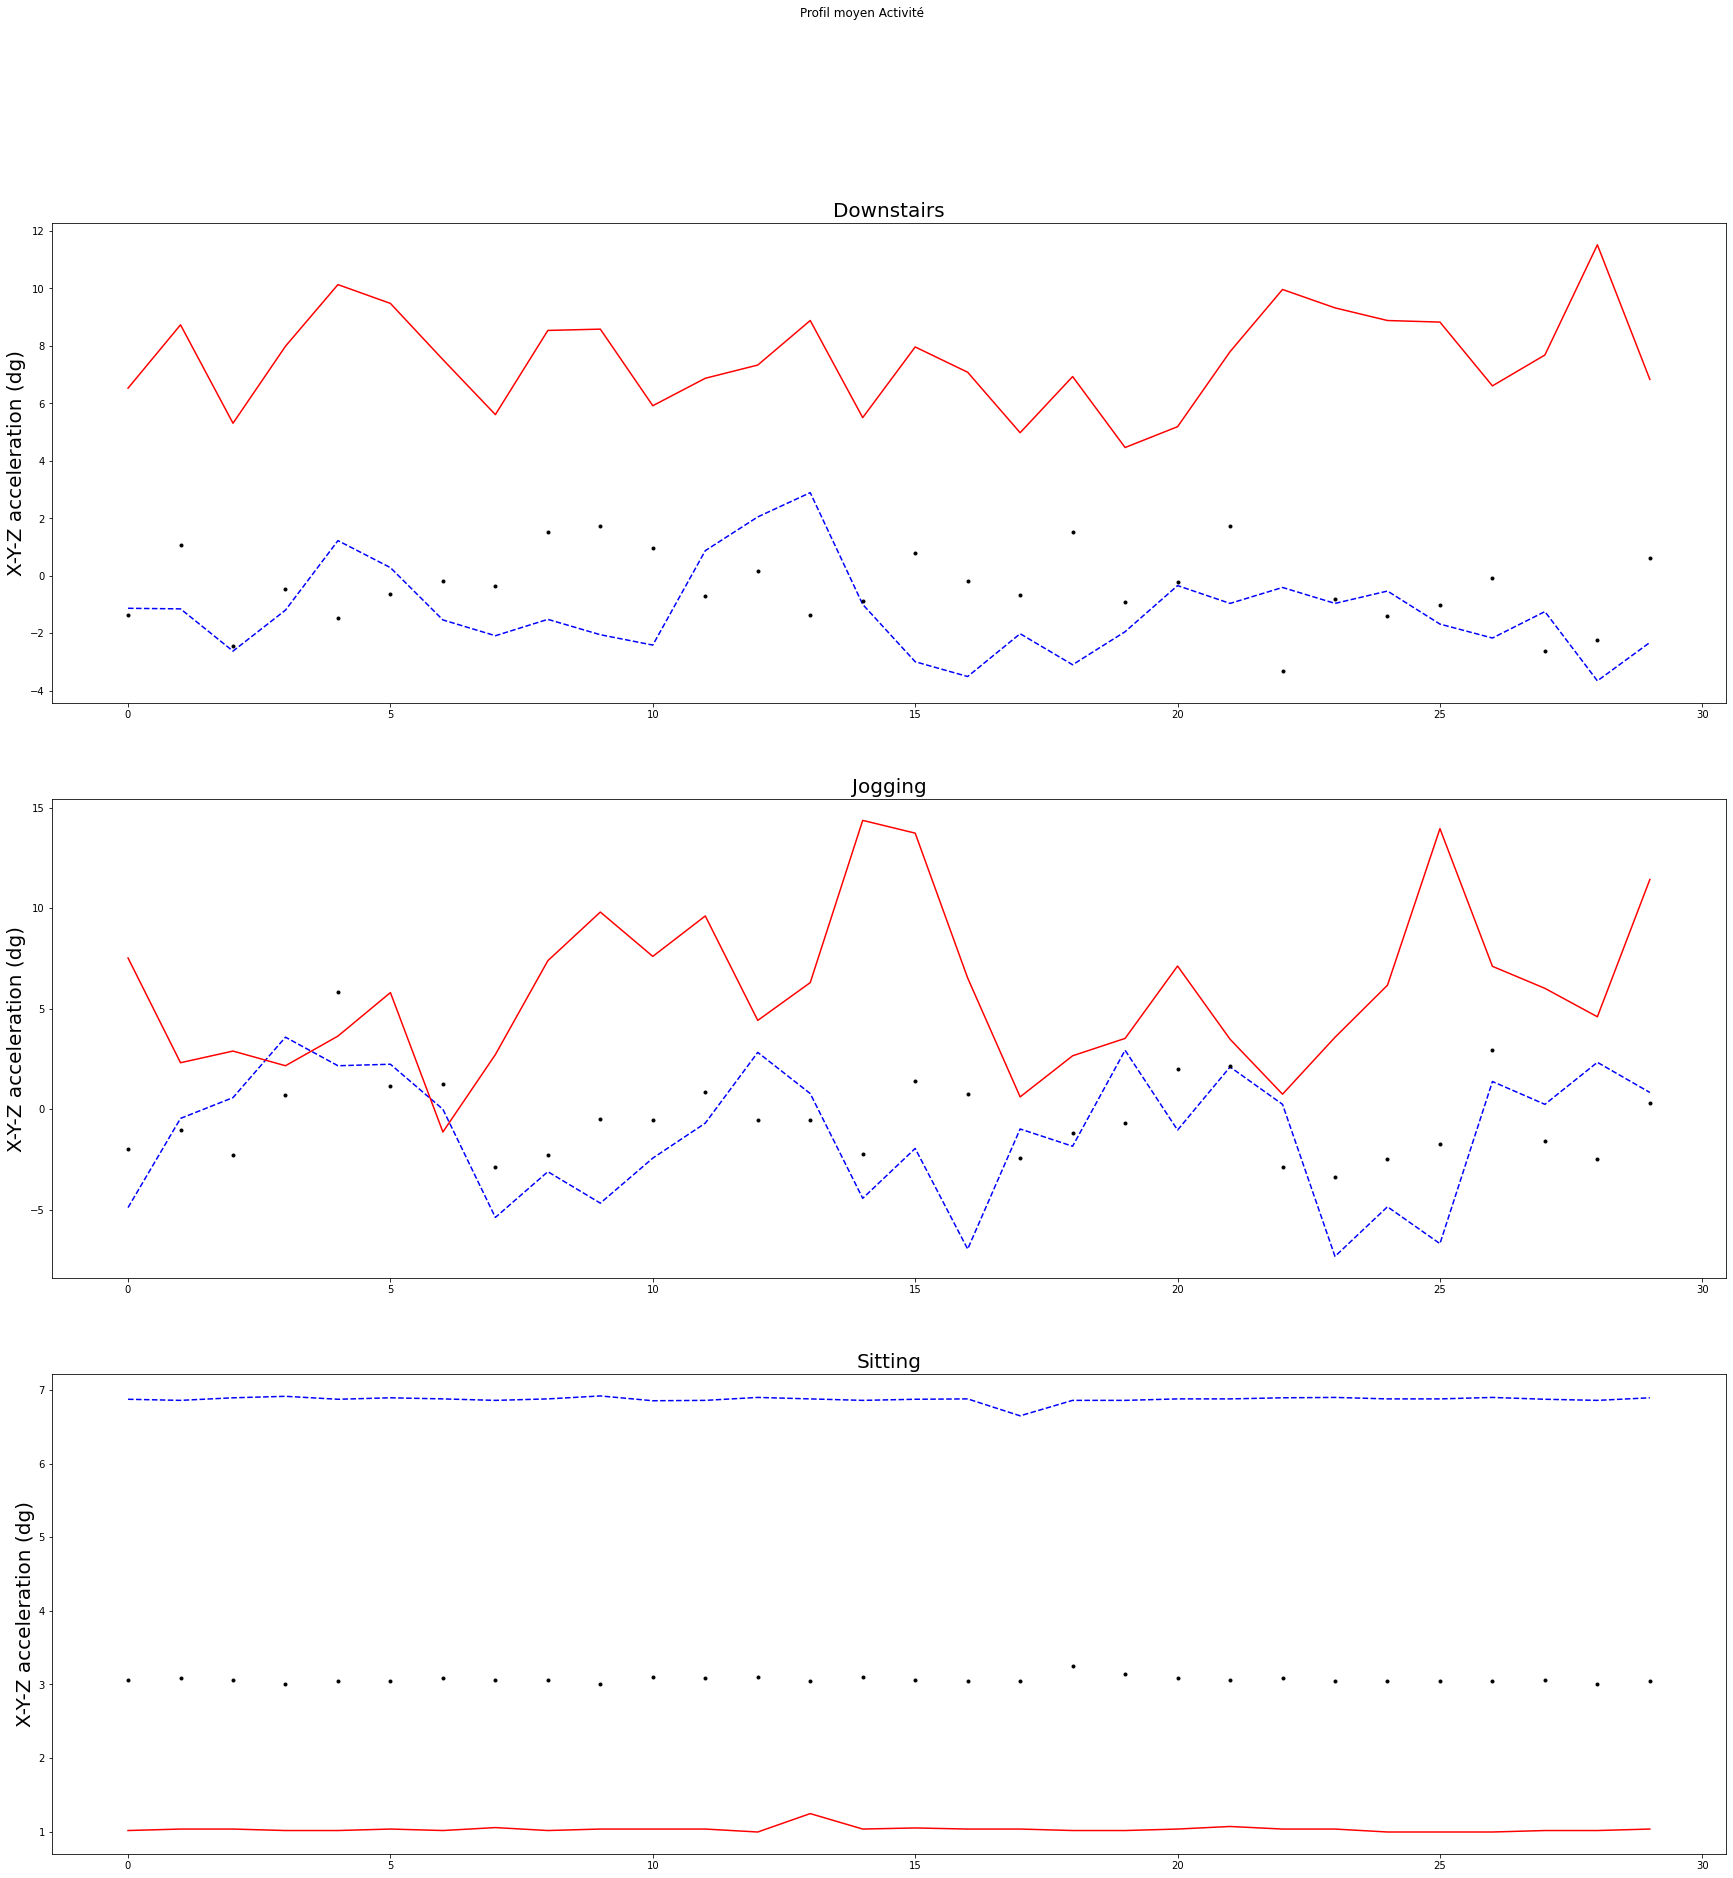

In [10]:
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)


**Conclusion: We see a similarity between Jogging and Sitting (especially between their x and y accelaritions) because they are both periodic whereas Sitting has almost constant x, y and z**

# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 

2. Afin d'adapter facilement le calcul des coûts suivant la nature des données (et donc des distances utilisées), écrivez une fonction pour chaque distance (euclidienne, lettres, sons) qui apparaîtra en paramètre de la fonction DTW.

In [11]:
# Fonction DTW à implémenter
from math import *
import numpy as np
import sys

def DTW(A, B, w1=1, w2=1, w3=1, norm=1, window=sys.maxsize, d=lambda x,y,norm: (np.linalg.norm((x-y))**norm)): 
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))

    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0], norm)
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0], norm)

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j], norm)
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i], B[j], norm)

    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path

In [12]:
# test changement contrainte locale
def DTW2(A, B, w1=1, w2=1, w3=1, norm=1, window=sys.maxsize, d=lambda x,y,norm: (np.linalg.norm((x-y))**norm)): 
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))

    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0], norm)
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0], norm)

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j], norm)
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i-2, j-1], w3*cost[i-1, j-3],w2*cost[i - 3, j - 2],w2*cost[i - 1, j - 2]
            cost[i, j] = min(choices) + d(A[i], B[j], norm)

    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path

### Application aux exercices 

 Testez vos programmes sur les exercices vus en TD. 



Score DTW entre les 2 séquences :  3.6


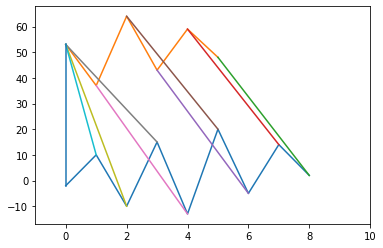

In [13]:
# Test sur exos de TDN_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# EX1
A=np.array([-2,10,-10,15,-13,20,-5,14,2])
B=np.array([3,-13,14,-7,9,-2])

cost, path = DTW(A, B, 1, 1, 1, 1, window = max(len(A),len(B)))
print('Score DTW entre les 2 séquences : ', cost)
    
offset = 50
plt.xlim([-1, max(len(A), len(B)) + 1])
plt.plot(A)
plt.plot(B+offset)
for (x1, x2) in path:
    plt.plot([x1, x2], [A[x1], B[x2] + offset])
plt.show()

Score DTW entre les 2 séquences :  1.5333333333333334


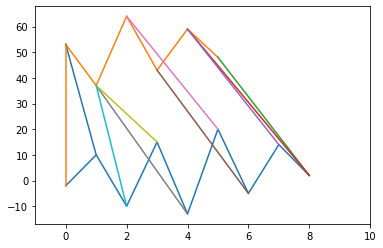

In [14]:
#TEST  DTW2 contrainte locale changée 
# Test sur exos de TDN_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# EX1
A=np.array([-2,10,-10,15,-13,20,-5,14,2])
B=np.array([3,-13,14,-7,9,-2])

cost, path = DTW2(A, B, 1, 1, 1, 1, window = max(len(A),len(B)))
print('Score DTW entre les 2 séquences : ', cost)
    
offset = 50
plt.xlim([-1, max(len(A), len(B)) + 1])
plt.plot(A)
plt.plot(B+offset)
for (x1, x2) in path:
    plt.plot([x1, x2], [A[x1], B[x2] + offset])
plt.show()

# Partie II : Système de reconnaissance d'activité physique avec la DTW



Pour chaque profil temporel test,
- Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 
- Déterminer la classe d'appartenance par minimum du score sur toutes les classes



In [15]:
PartitionDTW = np.zeros((TAILLE_TEST*N_CLASSES,2))

In [16]:
# Système de reconnaissance à partir de la DTW
def calcul_de_DTW(taille_test= TAILLE_TEST, Test_labels=Label_Test , number_Classes=N_CLASSES, List_Test_Data=List_Data_Test, convoluted_data=data_convoluted, profil=profil_moyen, w1=1,w2=1,w3=1, norm=1):
  print("On travaille avec taille test",taille_test," number of classes : ",number_Classes)
  
  for num in range(taille_test*number_Classes):
      #print('Donnee N°',num)
      result=np.zeros(number_Classes)
      for i in range(number_Classes):
          val=int(List_Test_Data[num])
          # A généraliser pour d'autres profils d'activité de la base 
          # d'apprentissage (pas seulement le profil moyen)
          cost,path = DTW(convoluted_data[val,:,:], profil[i,:,:], w1, w2, w3, norm)
          result[i]=cost
          index=np.argmin(result)
          PartitionDTW[num,0]=index
          PartitionDTW[num,1]=Test_labels[num]
  print(PartitionDTW.shape)

In [17]:
calcul_de_DTW()

On travaille avec taille test 30  number of classes :  3
(90, 2)


In [18]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def confusion_matrix_and_accuracy(PartitionDTW = PartitionDTW, LABELS = LABELS, N_CLASSES = N_CLASSES):
  print('Matrice de confusion par DTW')
  fig, ax = plt.subplots(figsize=(6,4))
  cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
  sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[:N_CLASSES]),yticklabels=np.unique(LABELS[:N_CLASSES]),annot=True)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')

  # score de performance
  print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

  #normalized matrix 
  cmn = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(6,4))
  sns.heatmap(data=cmn,fmt='.2f',xticklabels=np.unique(LABELS[:N_CLASSES]),yticklabels=np.unique(LABELS[:N_CLASSES]),annot=True)  
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show(block=False)

  print("Accuracy per class : ",cmn.diagonal())



Matrice de confusion par DTW
Accuracy sur base de test : 0.6444444444444445


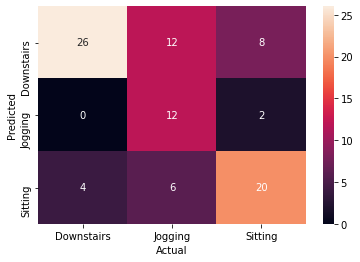

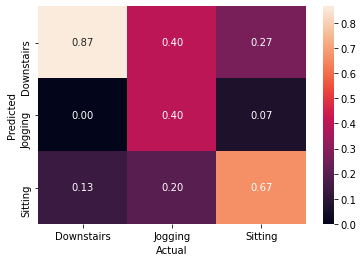

Accuracy per class :  [0.86666667 0.4        0.66666667]


In [19]:
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

# Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.





In [20]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




Dimension Base Apprentissage (30, 90)
(90, 30)
Dimension S (90, 90)


<ipython-input-21-3fa8181b9671>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  principalAxes[:,i]=eig_vecs[:,i]


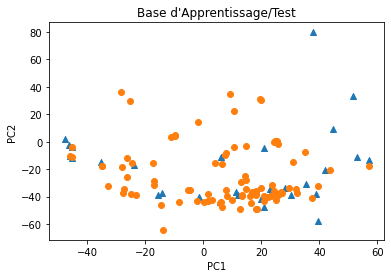

Contraste : (0.7013485154257457+0j)
0.7013485154257455


In [21]:
from sklearn.decomposition import PCA

n_components=5
print('Dimension Base Apprentissage',Data_App.shape)
#print(Data_Test.shape)

# En implémentant l'ACP 
T=np.transpose(Data_App)
print(T.shape)
cov_mat=np.cov(np.transpose(Data_App))
print('Dimension S',cov_mat.shape)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# affichage des points
#for i in range(0,N_CLASSES*TAILLE_APP):
plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
plt.title("Base d'Apprentissage/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()


# Pourcentage d'information conservée
Contraste=sum(eig_vals[range(n_components)])/sum(eig_vals)
print("Contraste :", Contraste)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

# affichage des points
#plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
#plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
#plt.title("Base d'Apprentissage/Test")
#plt.xlabel("PC1")
#plt.ylabel("PC2");
#plt.show()



# Conservation de l'information : Variance 
print(sum(pca.explained_variance_ratio_))


# Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<!---<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  > -->

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.




In [22]:
def KNN_result(n=1):
  error=[]
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(principalComponentsApp, Label_App)
  pred_i = knn.predict(principalComponentsTest)
  # Evaluation des résultats par matrices de confusion 
  print('Matrice de confusion avec ACP+kNN avec k =', n)
  cm=confusion_matrix(pred_i,Label_Test)
  sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[:N_CLASSES]),yticklabels=np.unique(LABELS[:N_CLASSES]),annot=True)
  # score de performance
  print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))

  #normalized matrix 
  cmn = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(6,4))
  sns.heatmap(data=cmn,fmt='.2f',xticklabels=np.unique(LABELS[:N_CLASSES]),yticklabels=np.unique(LABELS[:N_CLASSES]),annot=True)  
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show(block=False)

  print("Accuracy per class : ",cmn.diagonal())


 ################################ KNN AVEC K = 1 ################################
Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.6444444444444445


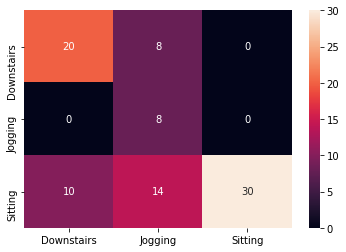

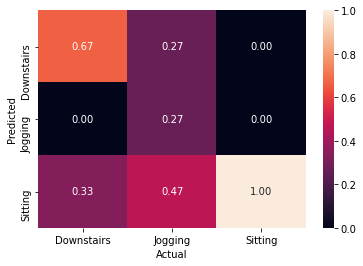

Accuracy per class :  [0.66666667 0.26666667 1.        ]


In [23]:
print(" ################################ KNN AVEC K = 1 ################################")
KNN_result()

# Partie IV : Votre étude

Réalisez votre propre étude en :
1. en Augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
2. en proposant des variantes (changement de norme pour la DTW, pondération différente pour les wi, contrainte locale, testez avec davantage de vecteurs propres pour l'ACP (utiliser le contraste)...)
3. en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les deux approches et en interprétant les résultats, à synthétiser sur un rapport. 


# Partie IV 1.

### Changement de taille de test et taille de APP


#### Augmentation taille APPRENTISSAGE

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(150, 90)
(90, 90)


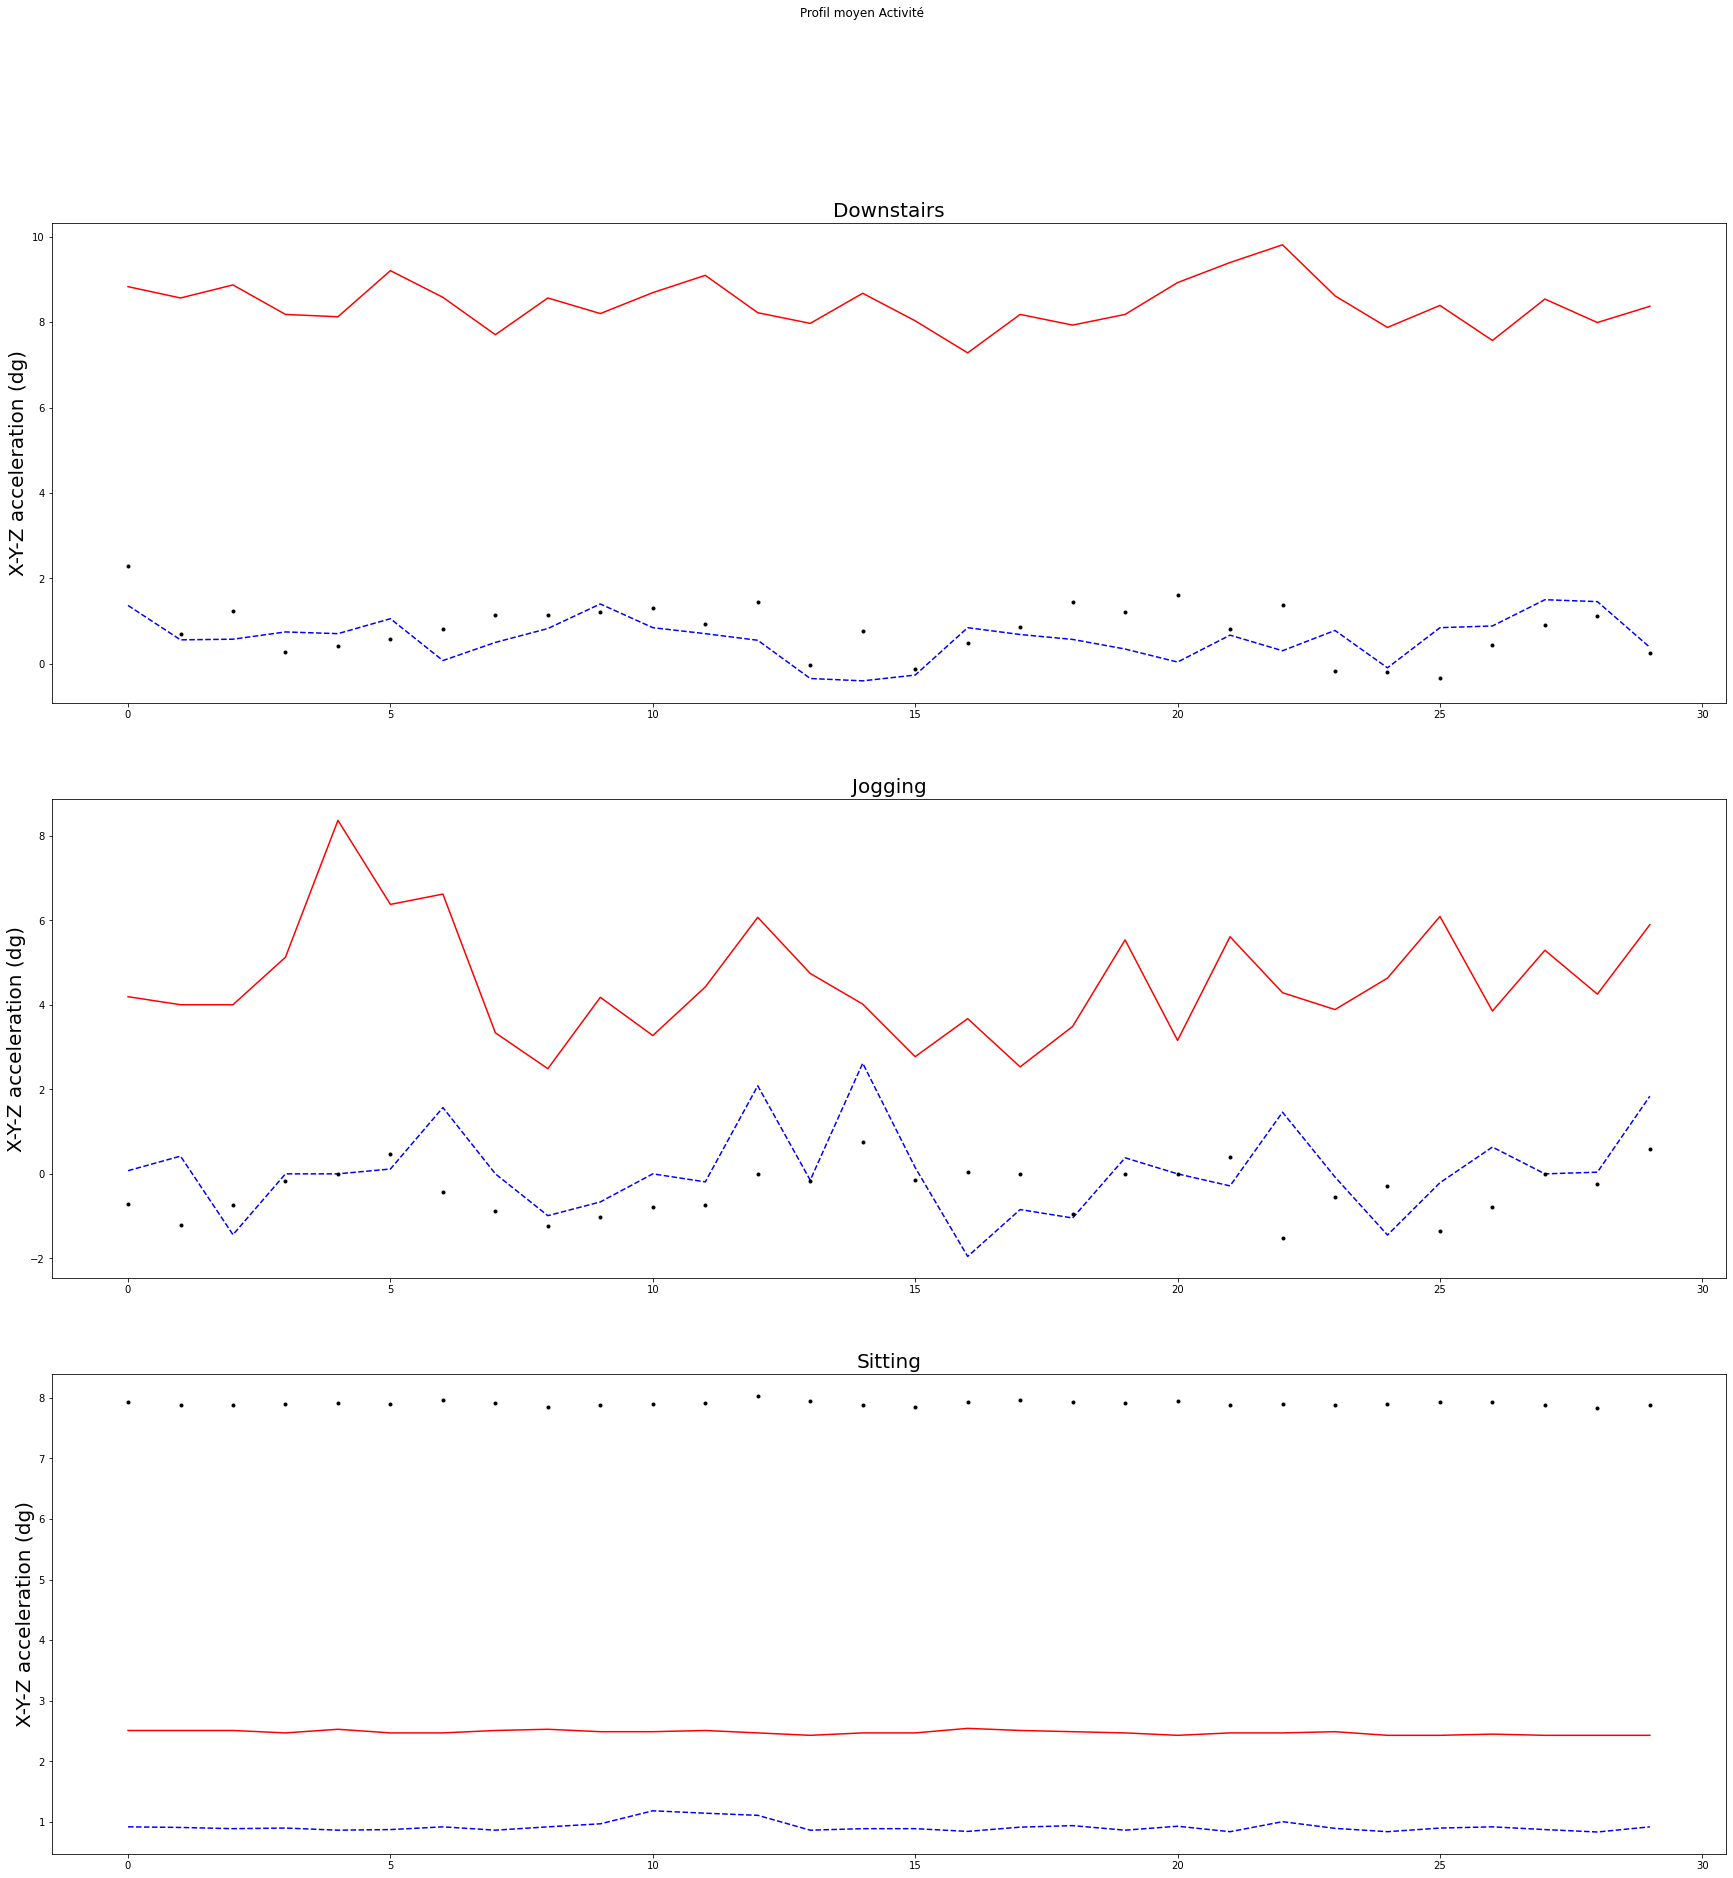

In [24]:
TAILLE_TEST=30
TAILLE_APP=50 #before 10
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

On travaille avec taille test 30  number of classes :  3
(90, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.7666666666666667


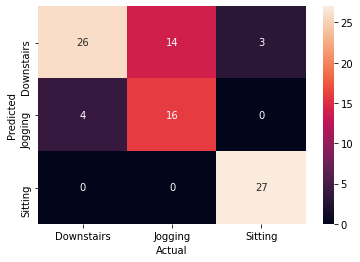

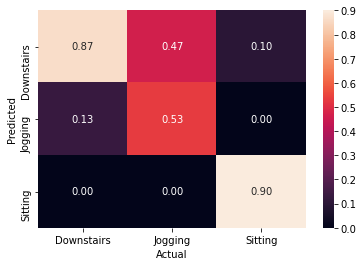

Accuracy per class :  [0.86666667 0.53333333 0.9       ]


In [25]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.8666666666666667


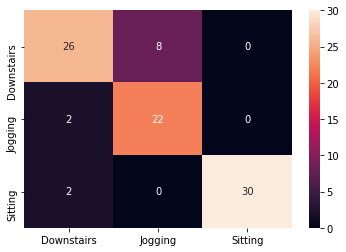

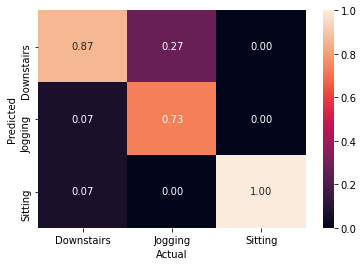

Accuracy per class :  [0.86666667 0.73333333 1.        ]


In [26]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

#### Augmentation taille TEST

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(30, 90)
(270, 90)


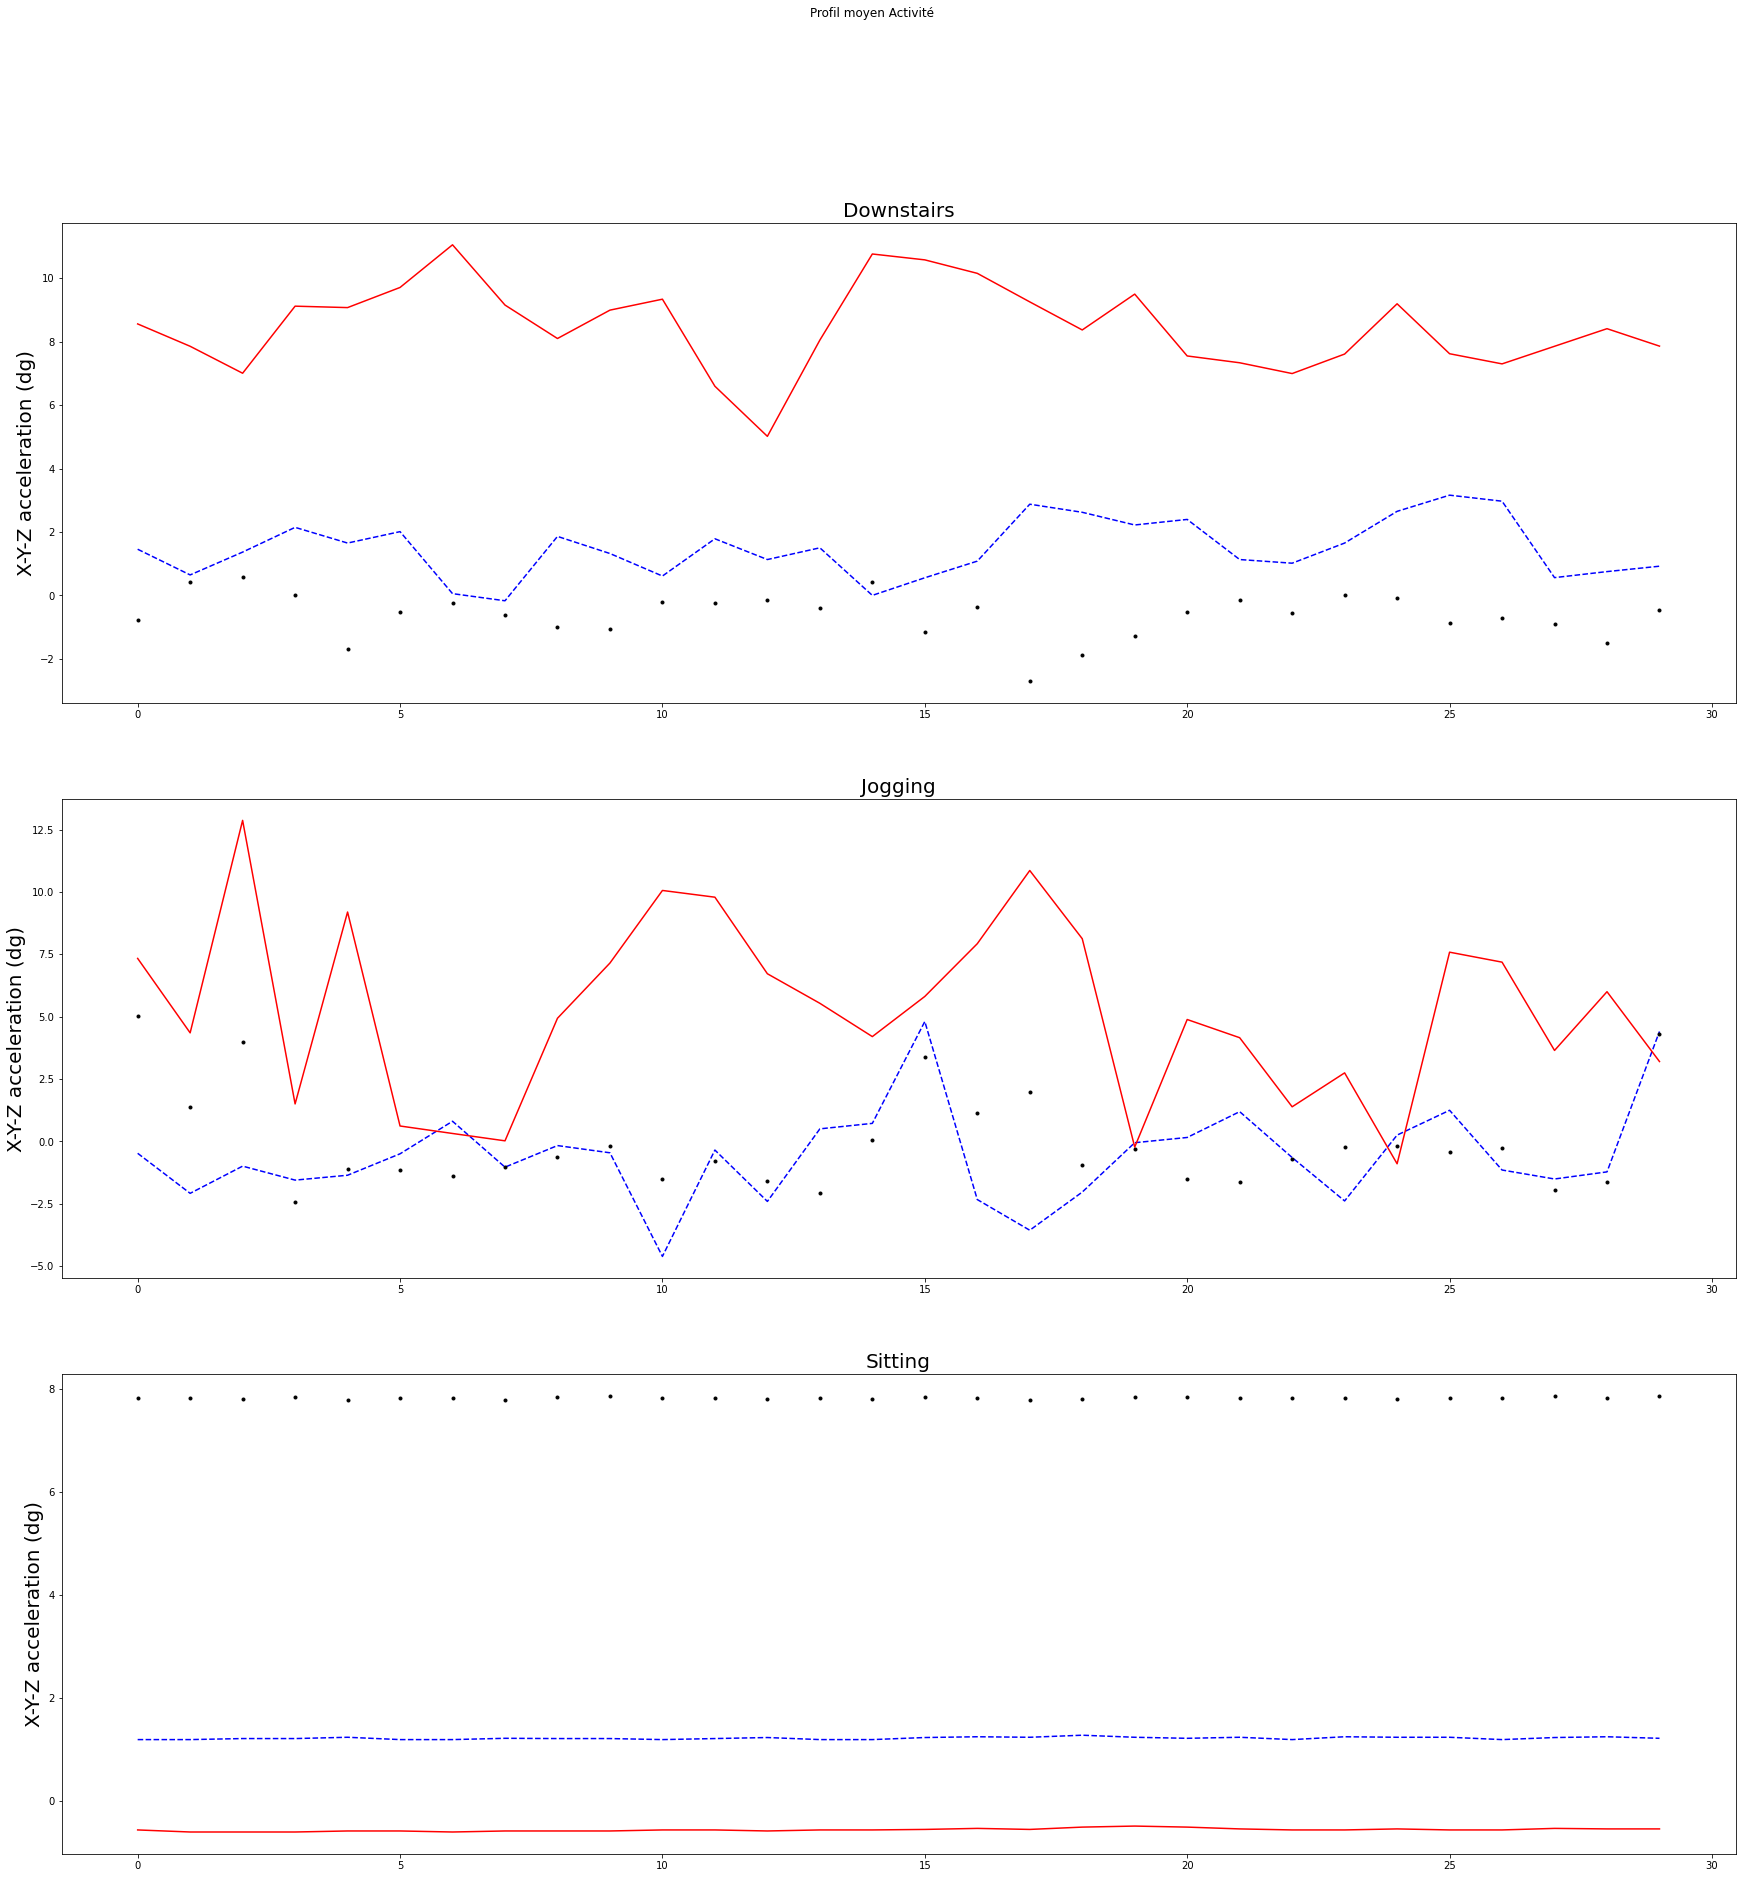

In [27]:
TAILLE_TEST=90 #before 30
TAILLE_APP=10 #before 10
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

On travaille avec taille test 90  number of classes :  3
(270, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.7962962962962963


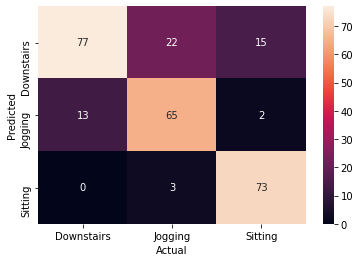

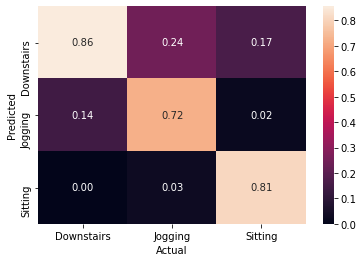

Accuracy per class :  [0.85555556 0.72222222 0.81111111]


In [28]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.7111111111111111


<ipython-input-29-3177f02c929d>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  principalAxes[:,i]=eig_vecs[:,i]


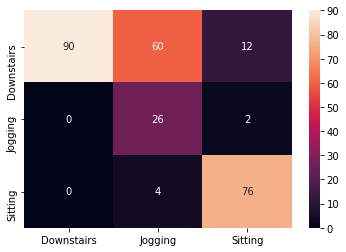

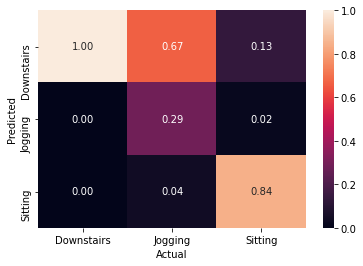

Accuracy per class :  [1.         0.28888889 0.84444444]


In [29]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

#### Augmentation taille de APP et de TEST

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(300, 90)
(360, 90)


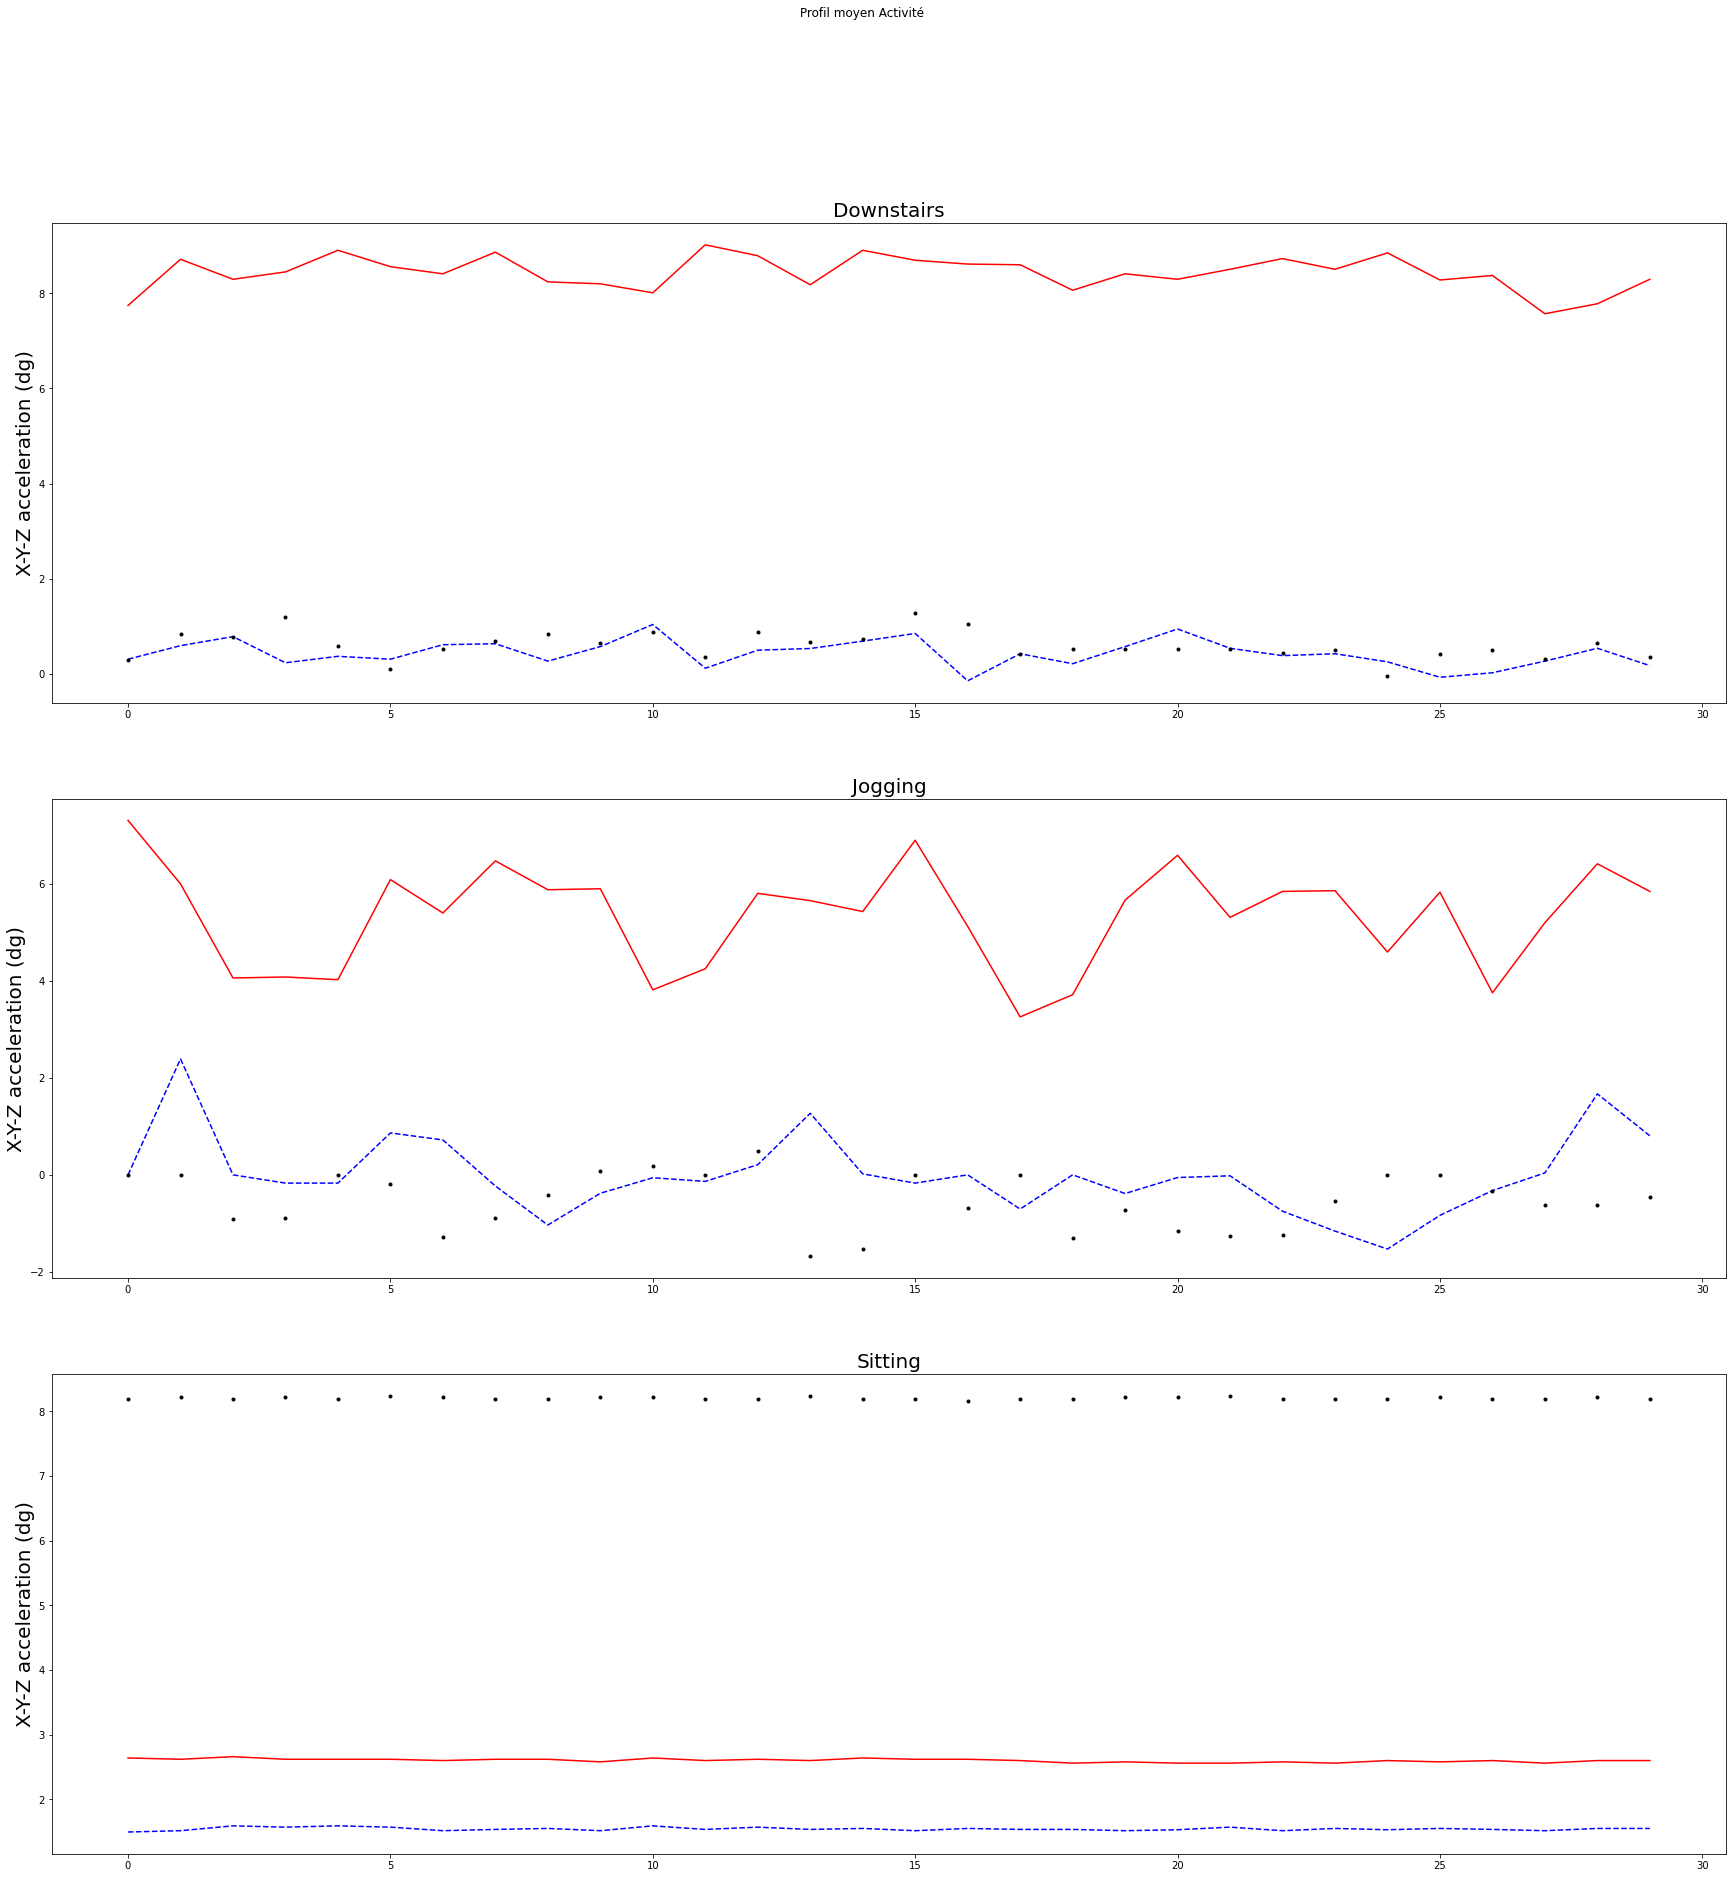

In [30]:
TAILLE_TEST=120 #before 30
TAILLE_APP=100 #before 10
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)


On travaille avec taille test 120  number of classes :  3
(360, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.8055555555555556


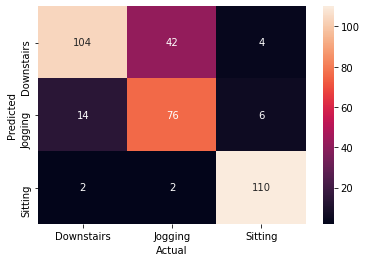

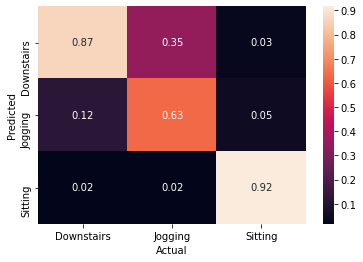

Accuracy per class :  [0.86666667 0.63333333 0.91666667]


In [31]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.8972222222222223


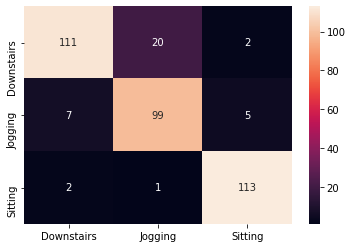

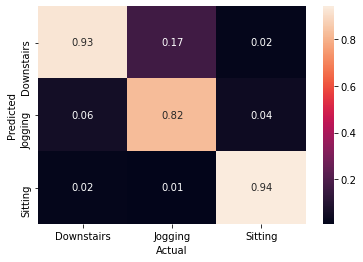

Accuracy per class :  [0.925      0.825      0.94166667]


In [32]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(30, 90)
(90, 90)


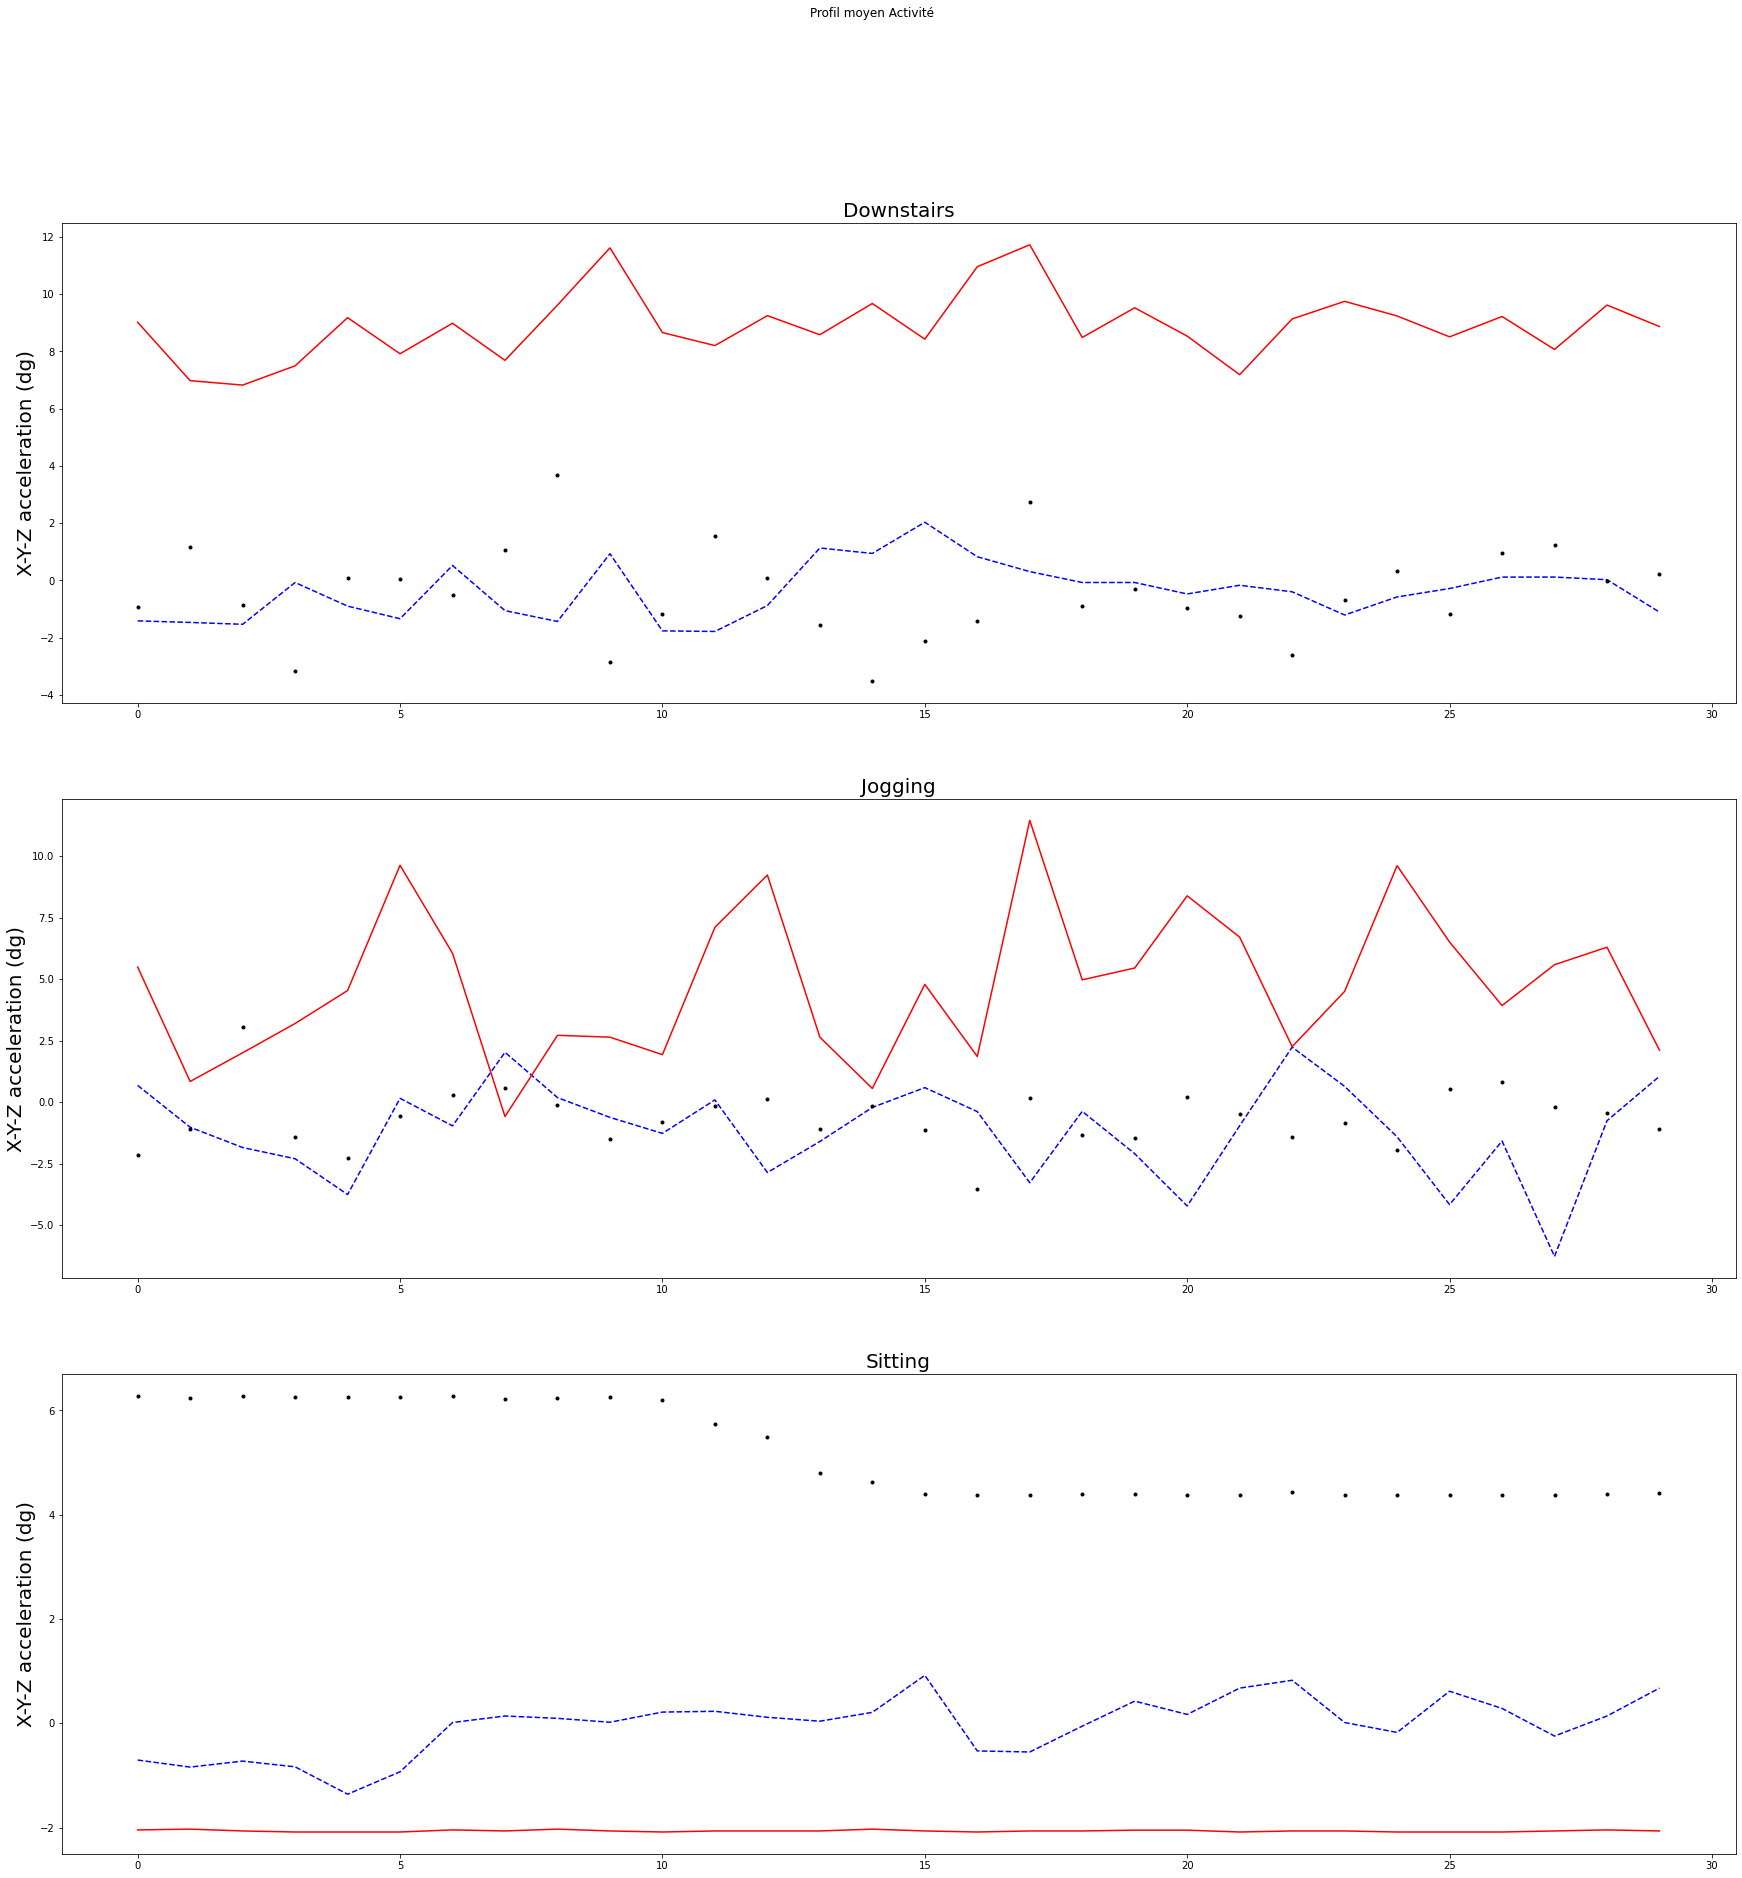

In [33]:
#Back to base params
TAILLE_TEST=30
TAILLE_APP=10
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

### Profil long

SEGMENT_TIME_SIZE = 60



Convoluted data shape:  (8373, 60, 3)
Labels shape: (8373,)
(8373, 60, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(30, 180)
(90, 180)
On travaille avec taille test 30  number of classes :  3
(90, 2)


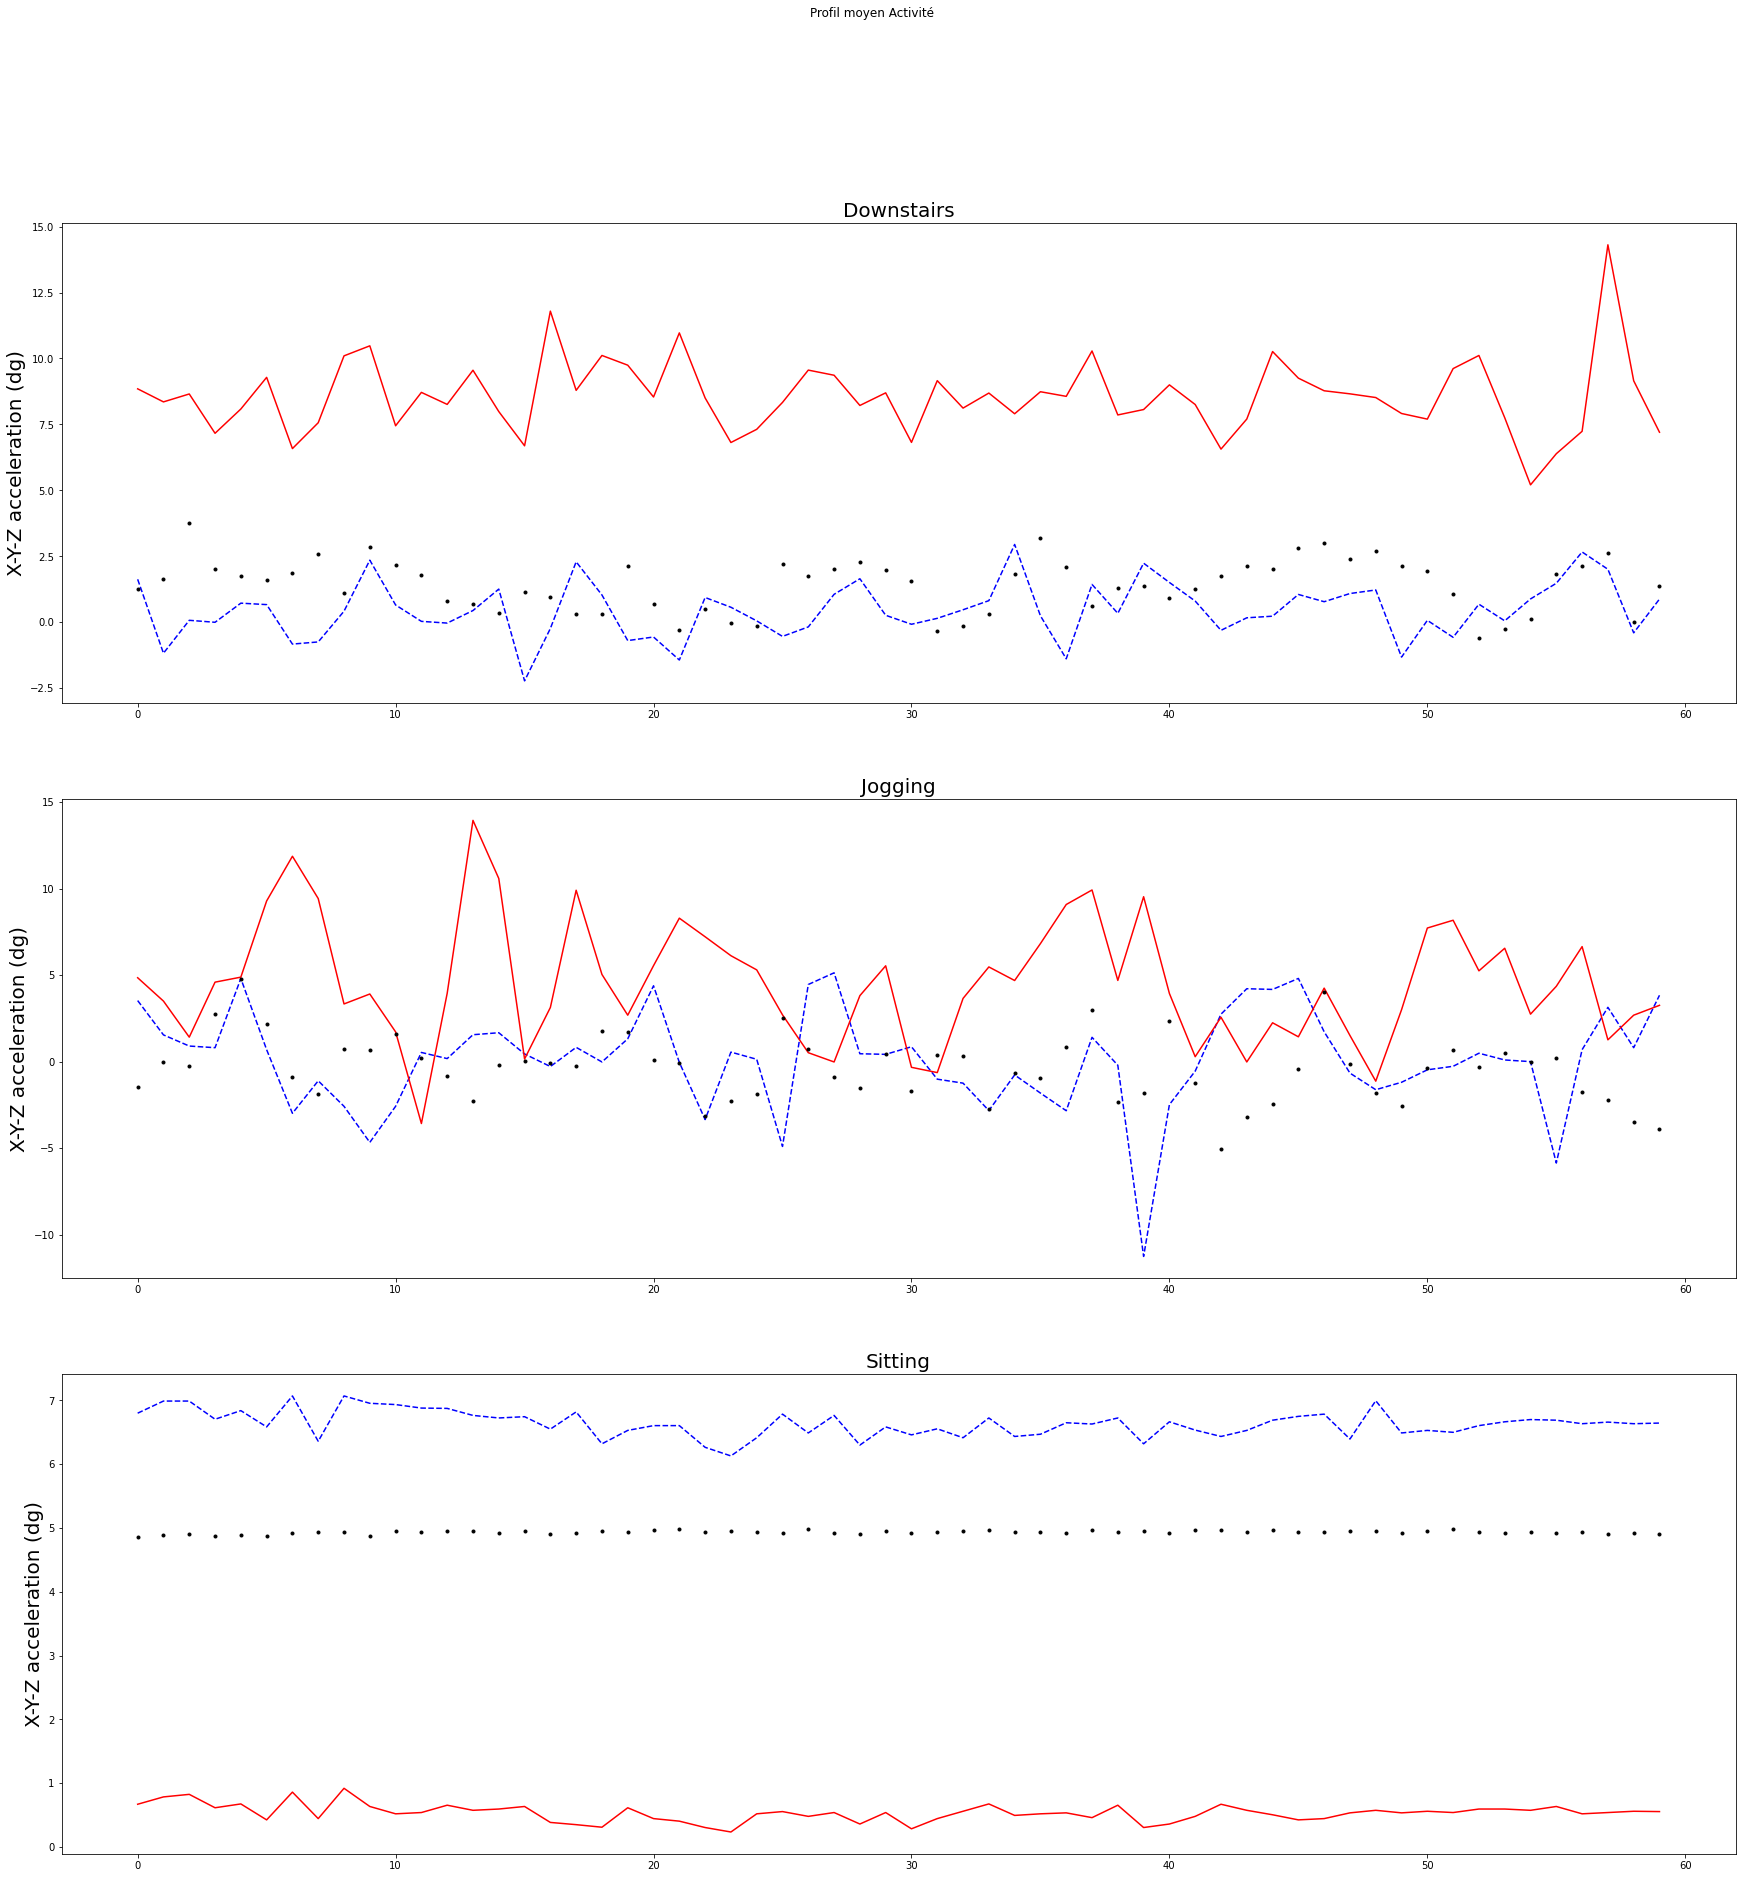

In [34]:
SEGMENT_TIME_SIZE= 60 #before 30
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)

Matrice de confusion par DTW
Accuracy sur base de test : 0.8555555555555555


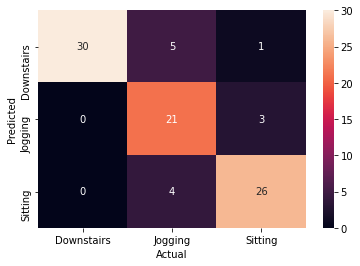

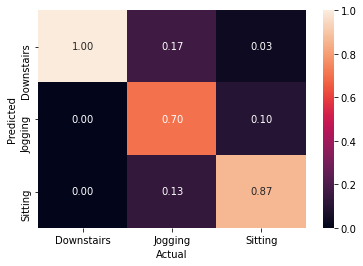

Accuracy per class :  [1.         0.7        0.86666667]


In [35]:
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1


<ipython-input-36-3177f02c929d>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  principalAxes[:,i]=eig_vecs[:,i]


Accuracy sur base de test : 0.7555555555555555


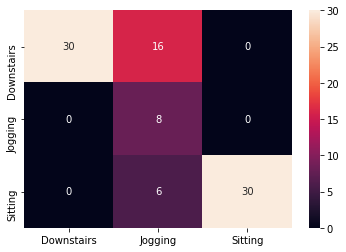

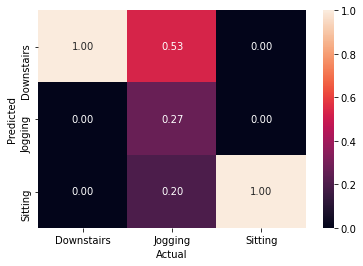

Accuracy per class :  [1.         0.26666667 1.        ]


In [36]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

### Profil Court

SEGMENT_TIME_SIZE = 15

Convoluted data shape:  (8376, 15, 3)
Labels shape: (8376,)
(8376, 15, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(30, 45)
(90, 45)
On travaille avec taille test 30  number of classes :  3
(90, 2)


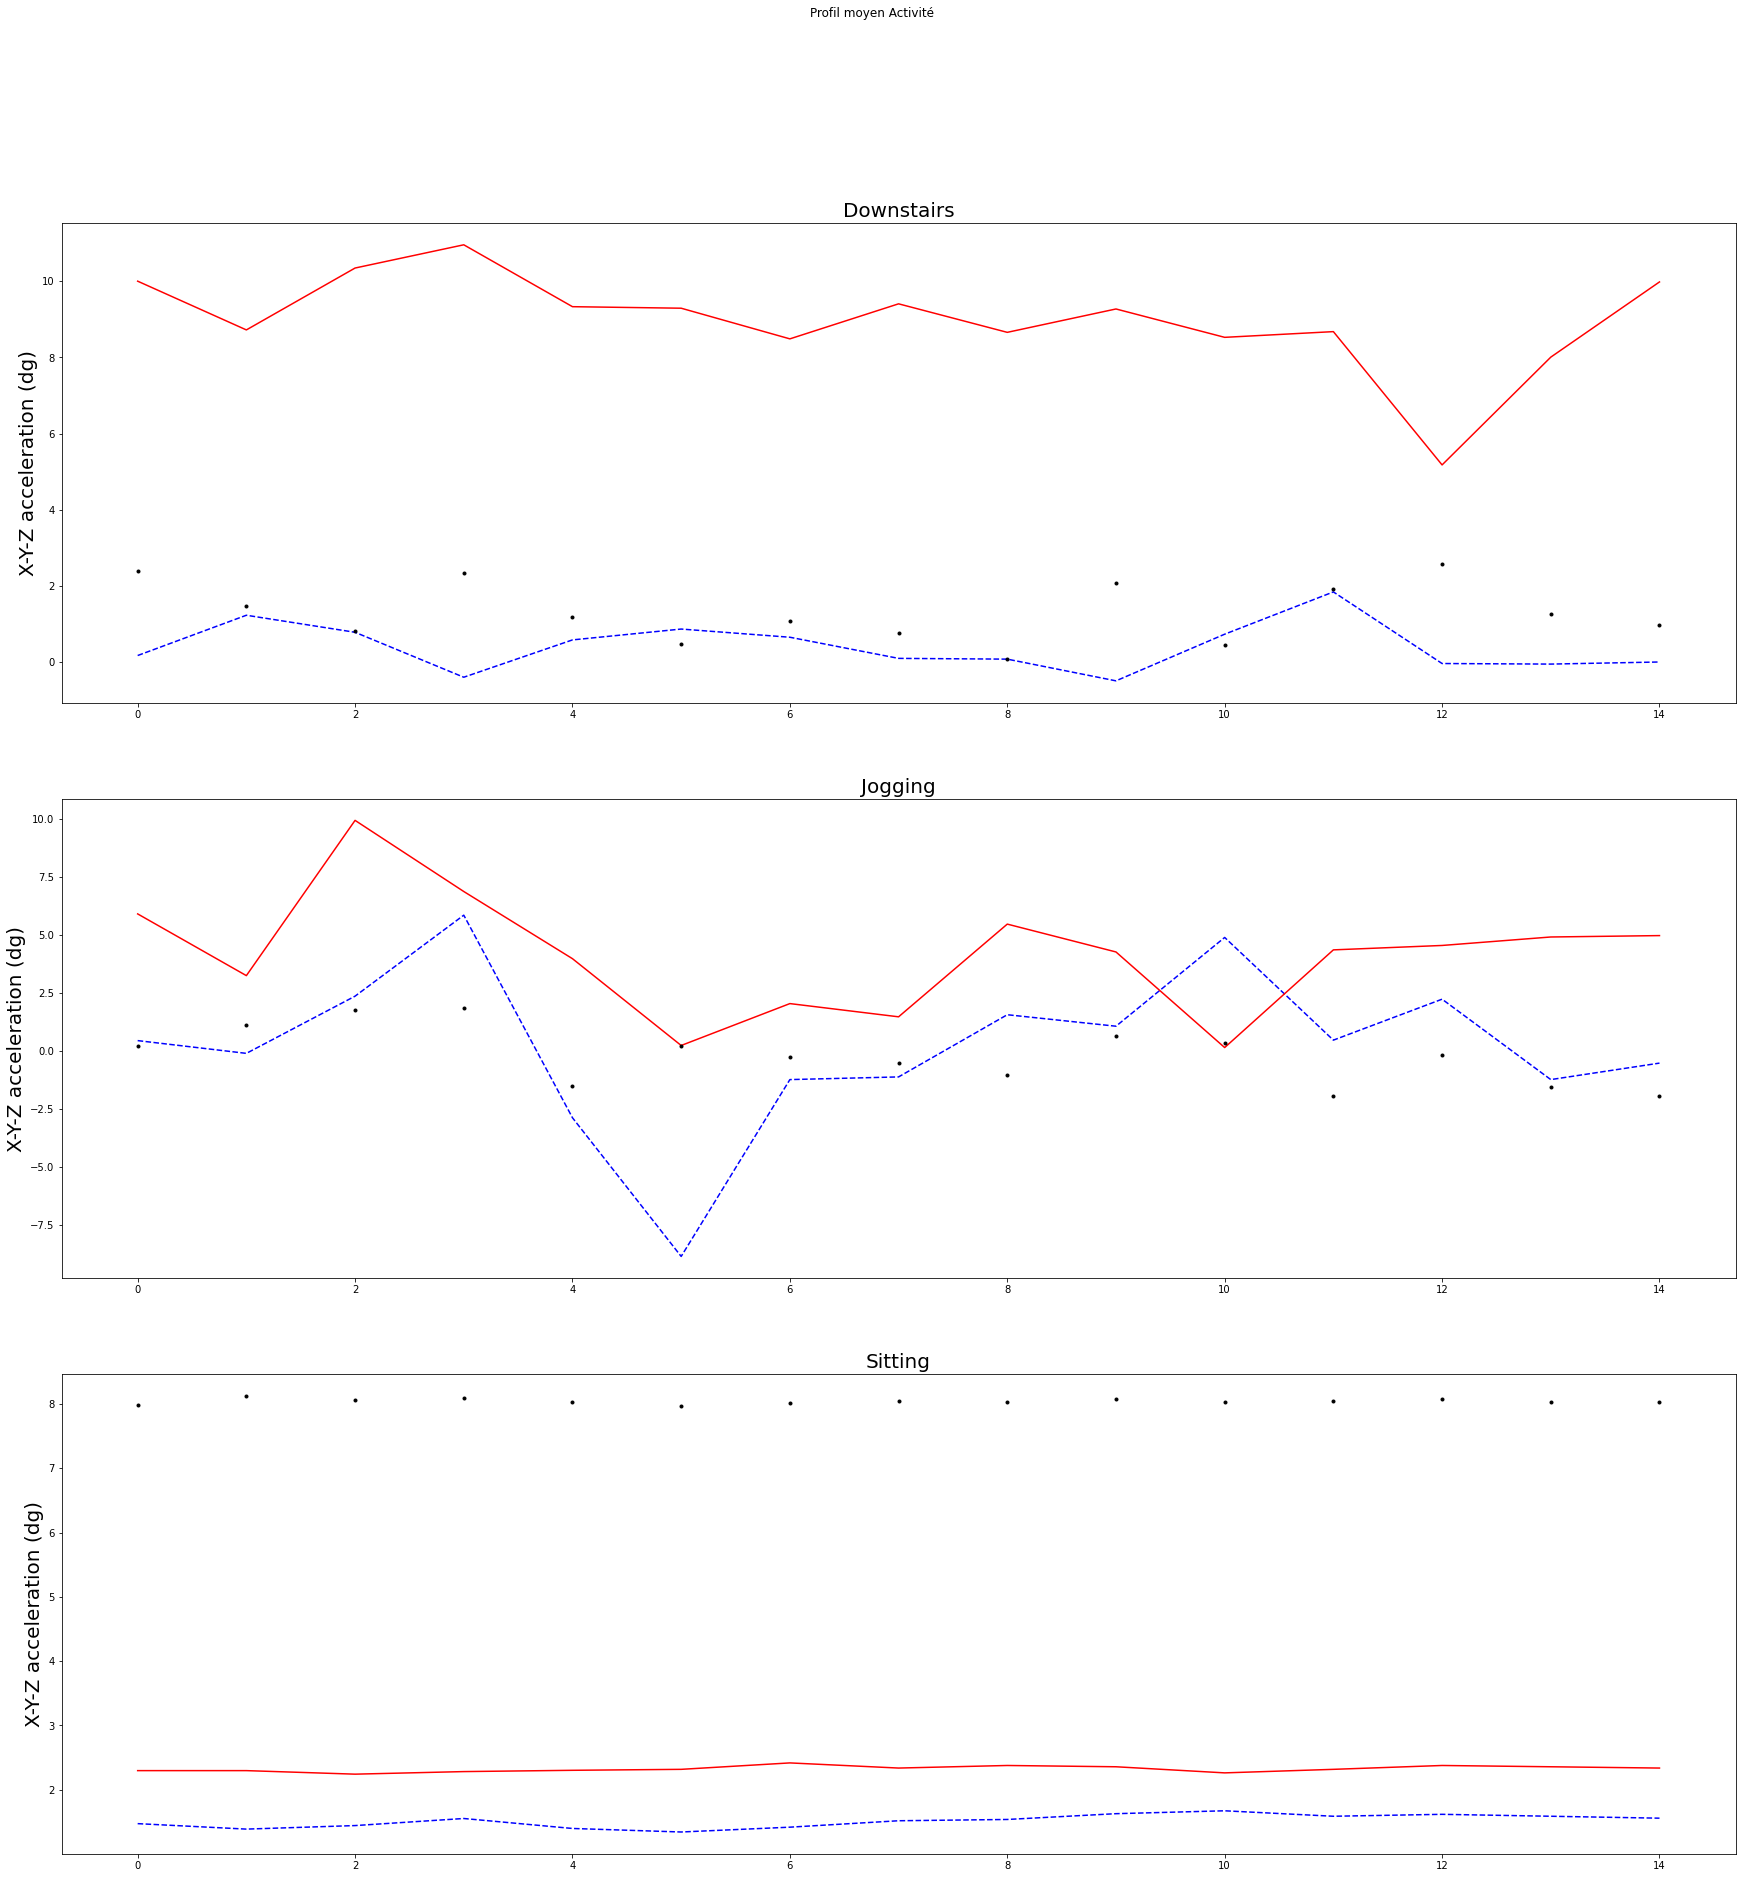

In [37]:
SEGMENT_TIME_SIZE= 15
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)


Matrice de confusion par DTW
Accuracy sur base de test : 0.8222222222222222


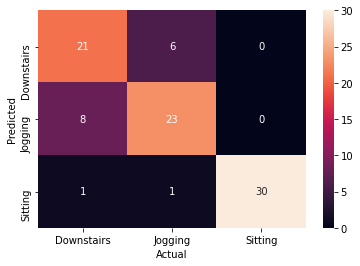

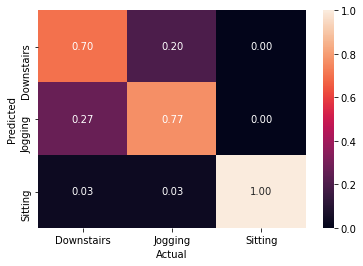

Accuracy per class :  [0.7        0.76666667 1.        ]


In [38]:
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.8


<ipython-input-39-3177f02c929d>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  principalAxes[:,i]=eig_vecs[:,i]


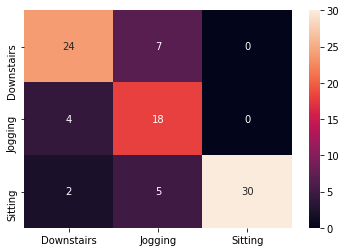

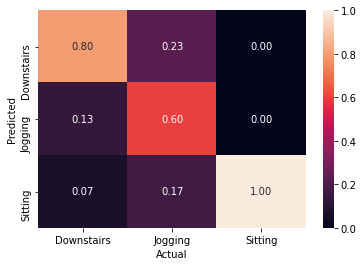

Accuracy per class :  [0.8 0.6 1. ]


In [39]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

# Partie IV 2.

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(30, 90)
(90, 90)
On travaille avec taille test 30  number of classes :  3
(90, 2)


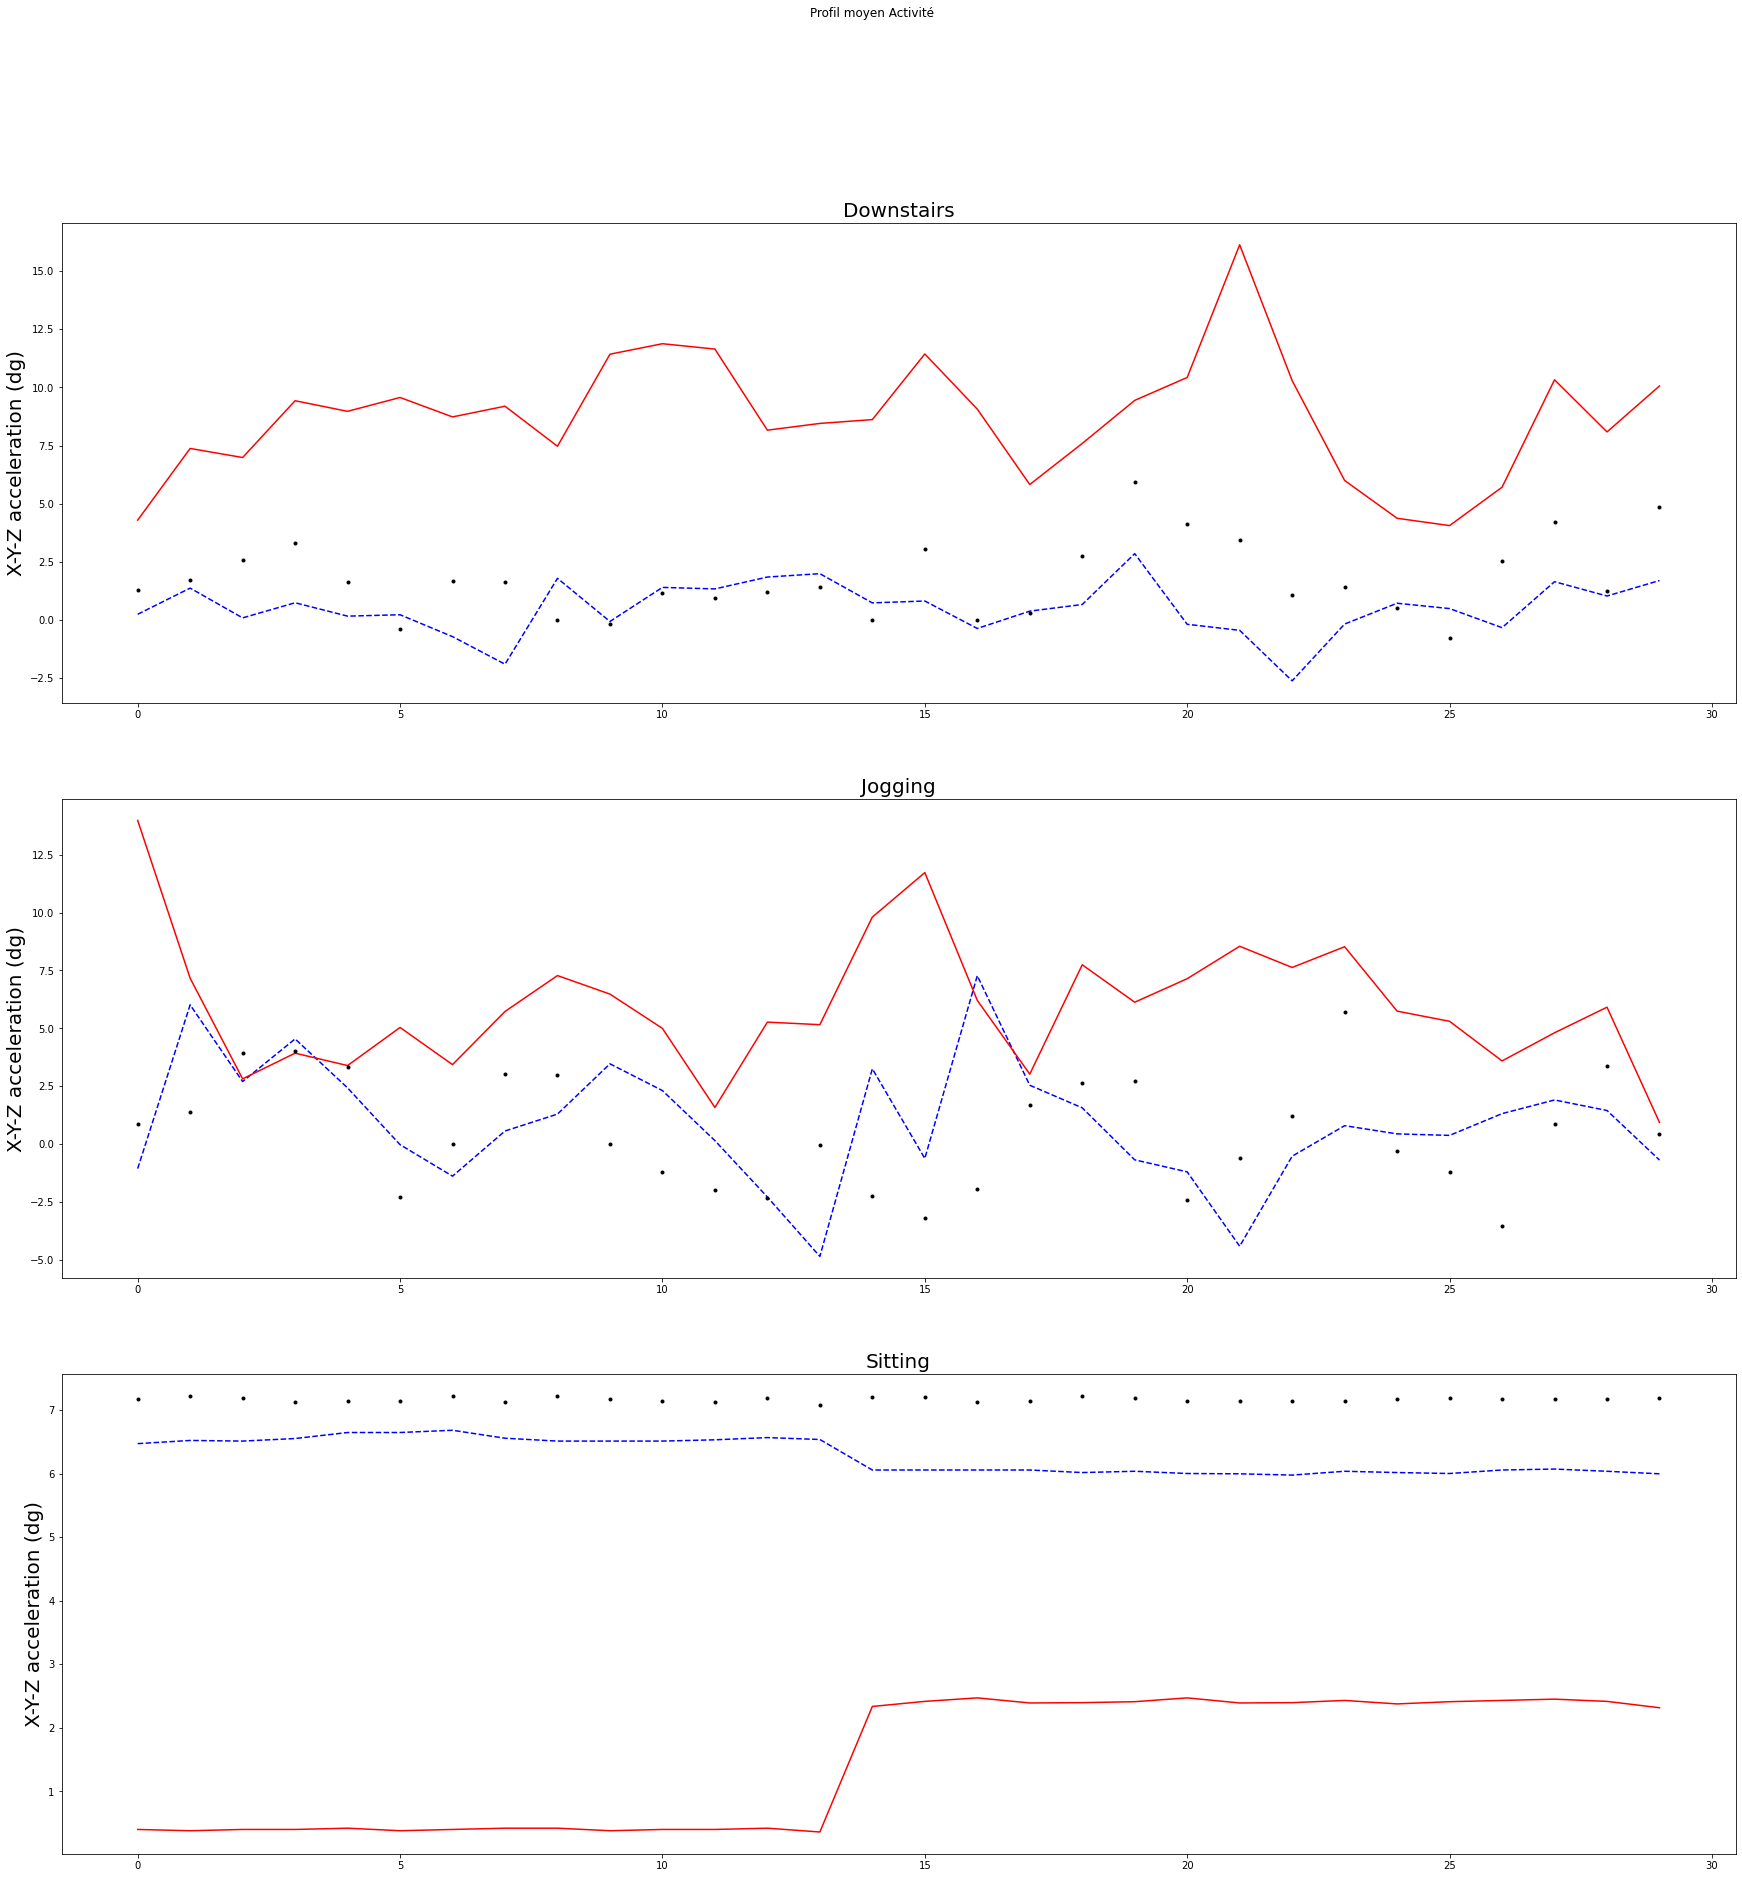

In [40]:
# ReSetting to base params
SEGMENT_TIME_SIZE= 30
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)

### TEST - Calcul du score avec differents poids
 Pondération des Chemins 

 Pondération asymétrique 1 : **weight** changed `w1=1` `w2=2` et `w1=1`

On travaille avec taille test 30  number of classes :  3
(90, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.7444444444444445


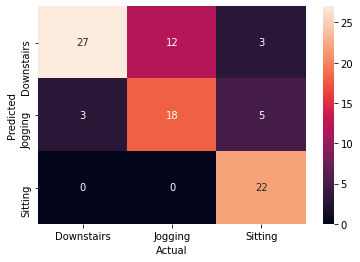

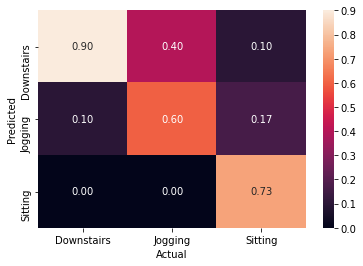

Accuracy per class :  [0.9        0.6        0.73333333]


In [41]:
PartitionDTW = np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen , 1,2,1)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

### TEST - Calcul du score avec different Norm de DTW


On travaille avec taille test 30  number of classes :  3
(90, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.8444444444444444


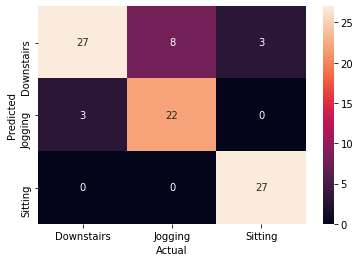

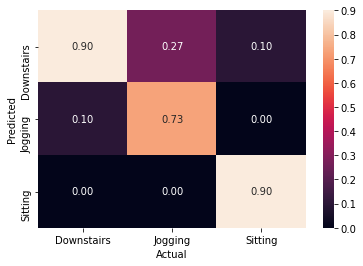

Accuracy per class :  [0.9        0.73333333 0.9       ]


In [42]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen , 1,1,1, 2)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

On travaille avec taille test 30  number of classes :  3
(90, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.8222222222222222


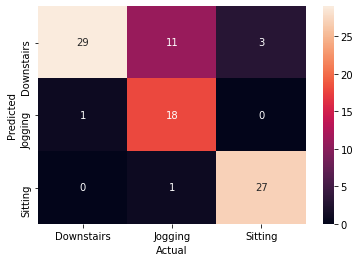

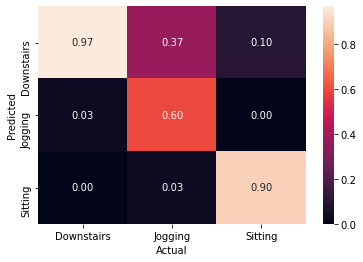

Accuracy per class :  [0.96666667 0.6        0.9       ]


In [43]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen , 1,1,1, 0.5)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

On travaille avec taille test 30  number of classes :  3
(90, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.8444444444444444


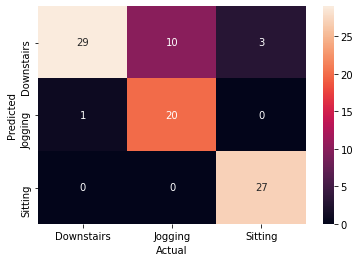

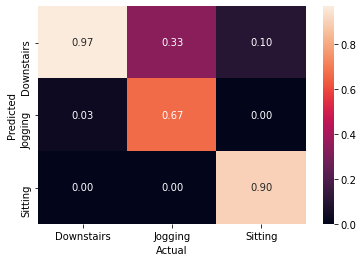

Accuracy per class :  [0.96666667 0.66666667 0.9       ]


In [44]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen , 1,1,1, 1.1)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

### TEST - Calcul avec different N de KNN

Matrice de confusion avec ACP+kNN avec k = 3
Accuracy sur base de test : 0.7


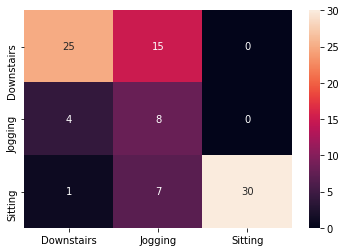

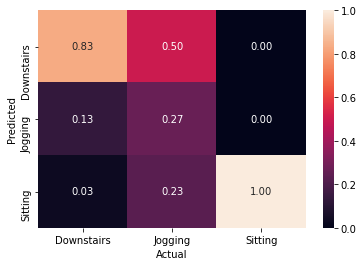

Accuracy per class :  [0.83333333 0.26666667 1.        ]


In [45]:
KNN_result(3)

Matrice de confusion avec ACP+kNN avec k = 10
Accuracy sur base de test : 0.6555555555555556


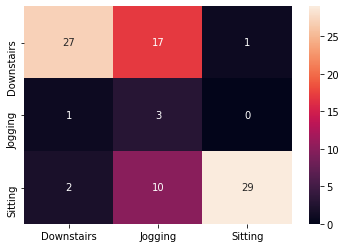

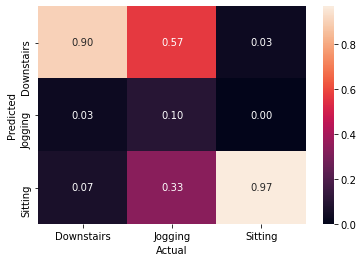

Accuracy per class :  [0.9        0.1        0.96666667]


In [46]:
KNN_result(10)

# Partie IV 3. : 6 CLASSES

Convoluted data shape:  (18304, 30, 3)
Labels shape: (18304,)
(18304, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
Classe N° 3
Classe N° 4
Classe N° 5
(60, 90)
(180, 90)


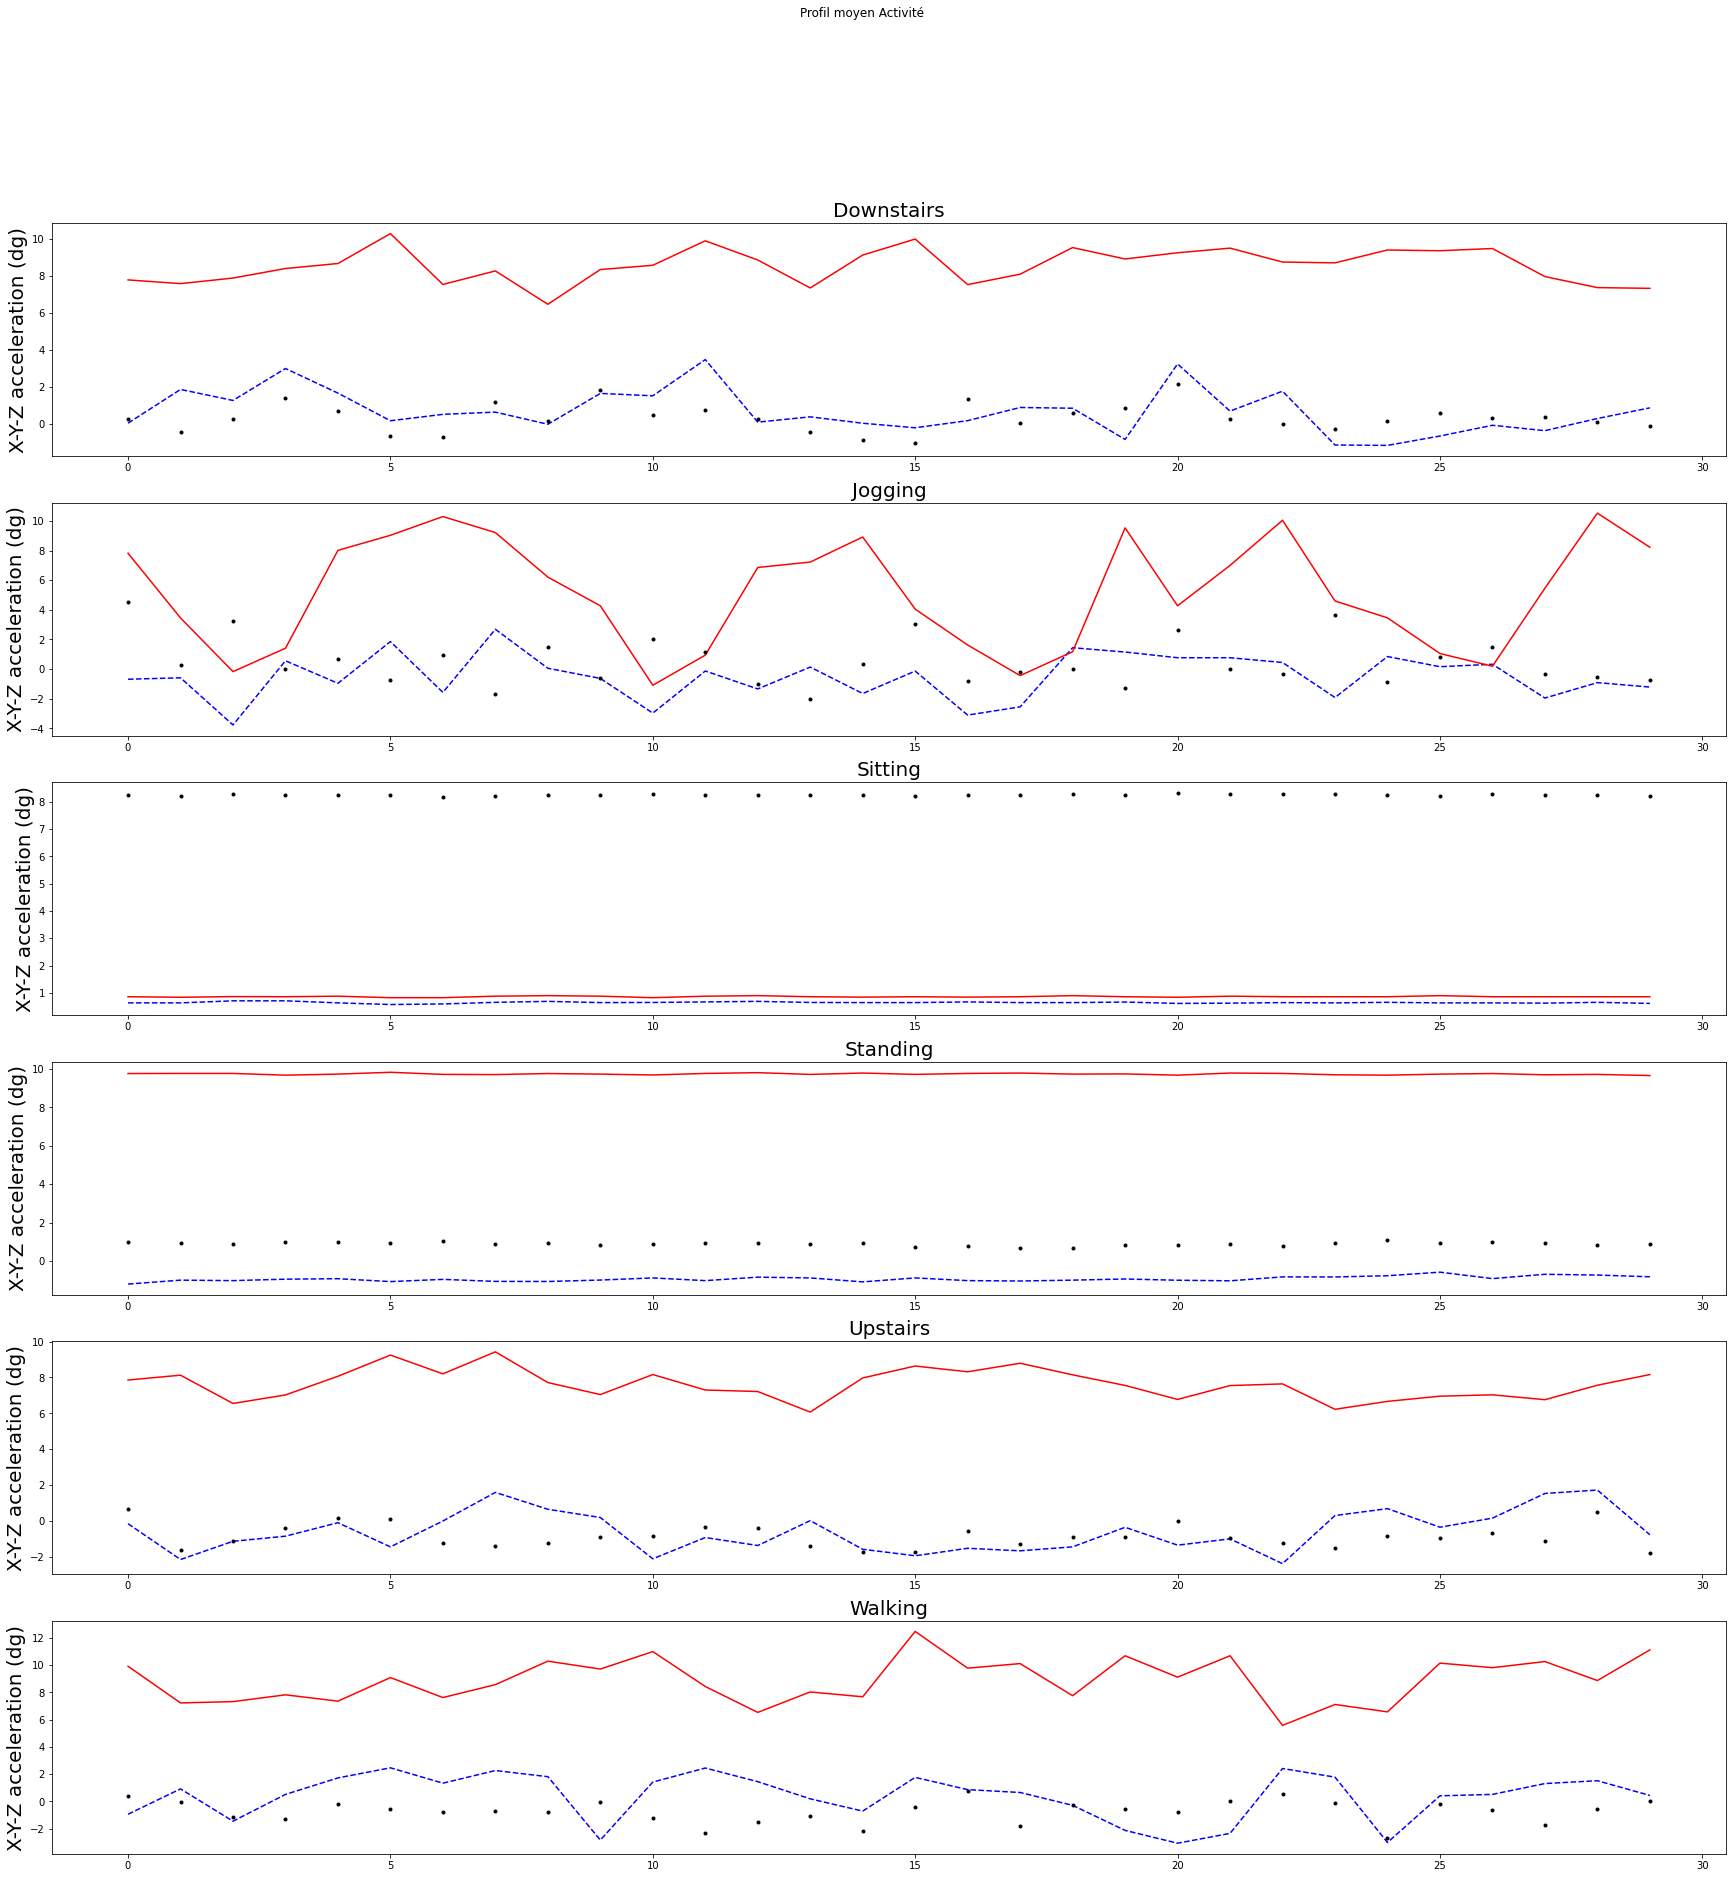

In [47]:
N_CLASSES = 6
SEGMENT_TIME_SIZE = 30
profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

On travaille avec taille test 30  number of classes :  6
(180, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.46111111111111114


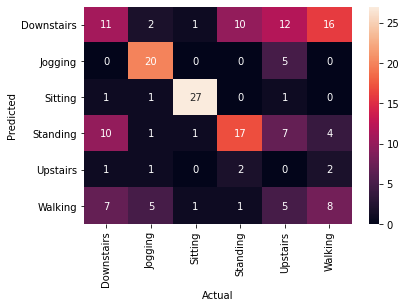

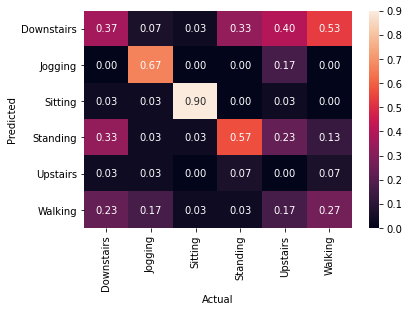

Accuracy per class :  [0.36666667 0.66666667 0.9        0.56666667 0.         0.26666667]


In [48]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen)
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1


<ipython-input-49-cb82042a9c47>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  principalAxes[:,i]=eig_vecs[:,i]


Accuracy sur base de test : 0.3888888888888889


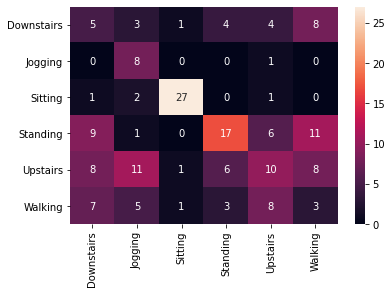

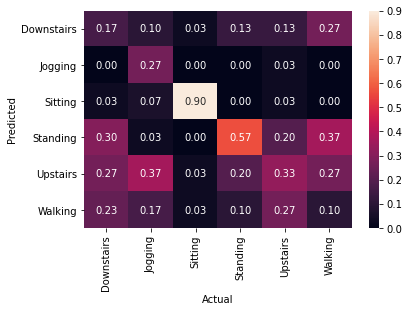

Accuracy per class :  [0.16666667 0.26666667 0.9        0.56666667 0.33333333 0.1       ]


In [49]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

**Conclusion: Giving more labels to the same amount of data gives worse accuracy**

## With improved params

Convoluted data shape:  (18299, 60, 3)
Labels shape: (18299,)
(18299, 60, 3)
Classe N° 0
Classe N° 1
Classe N° 2
Classe N° 3
Classe N° 4
Classe N° 5
(720, 180)
(600, 180)


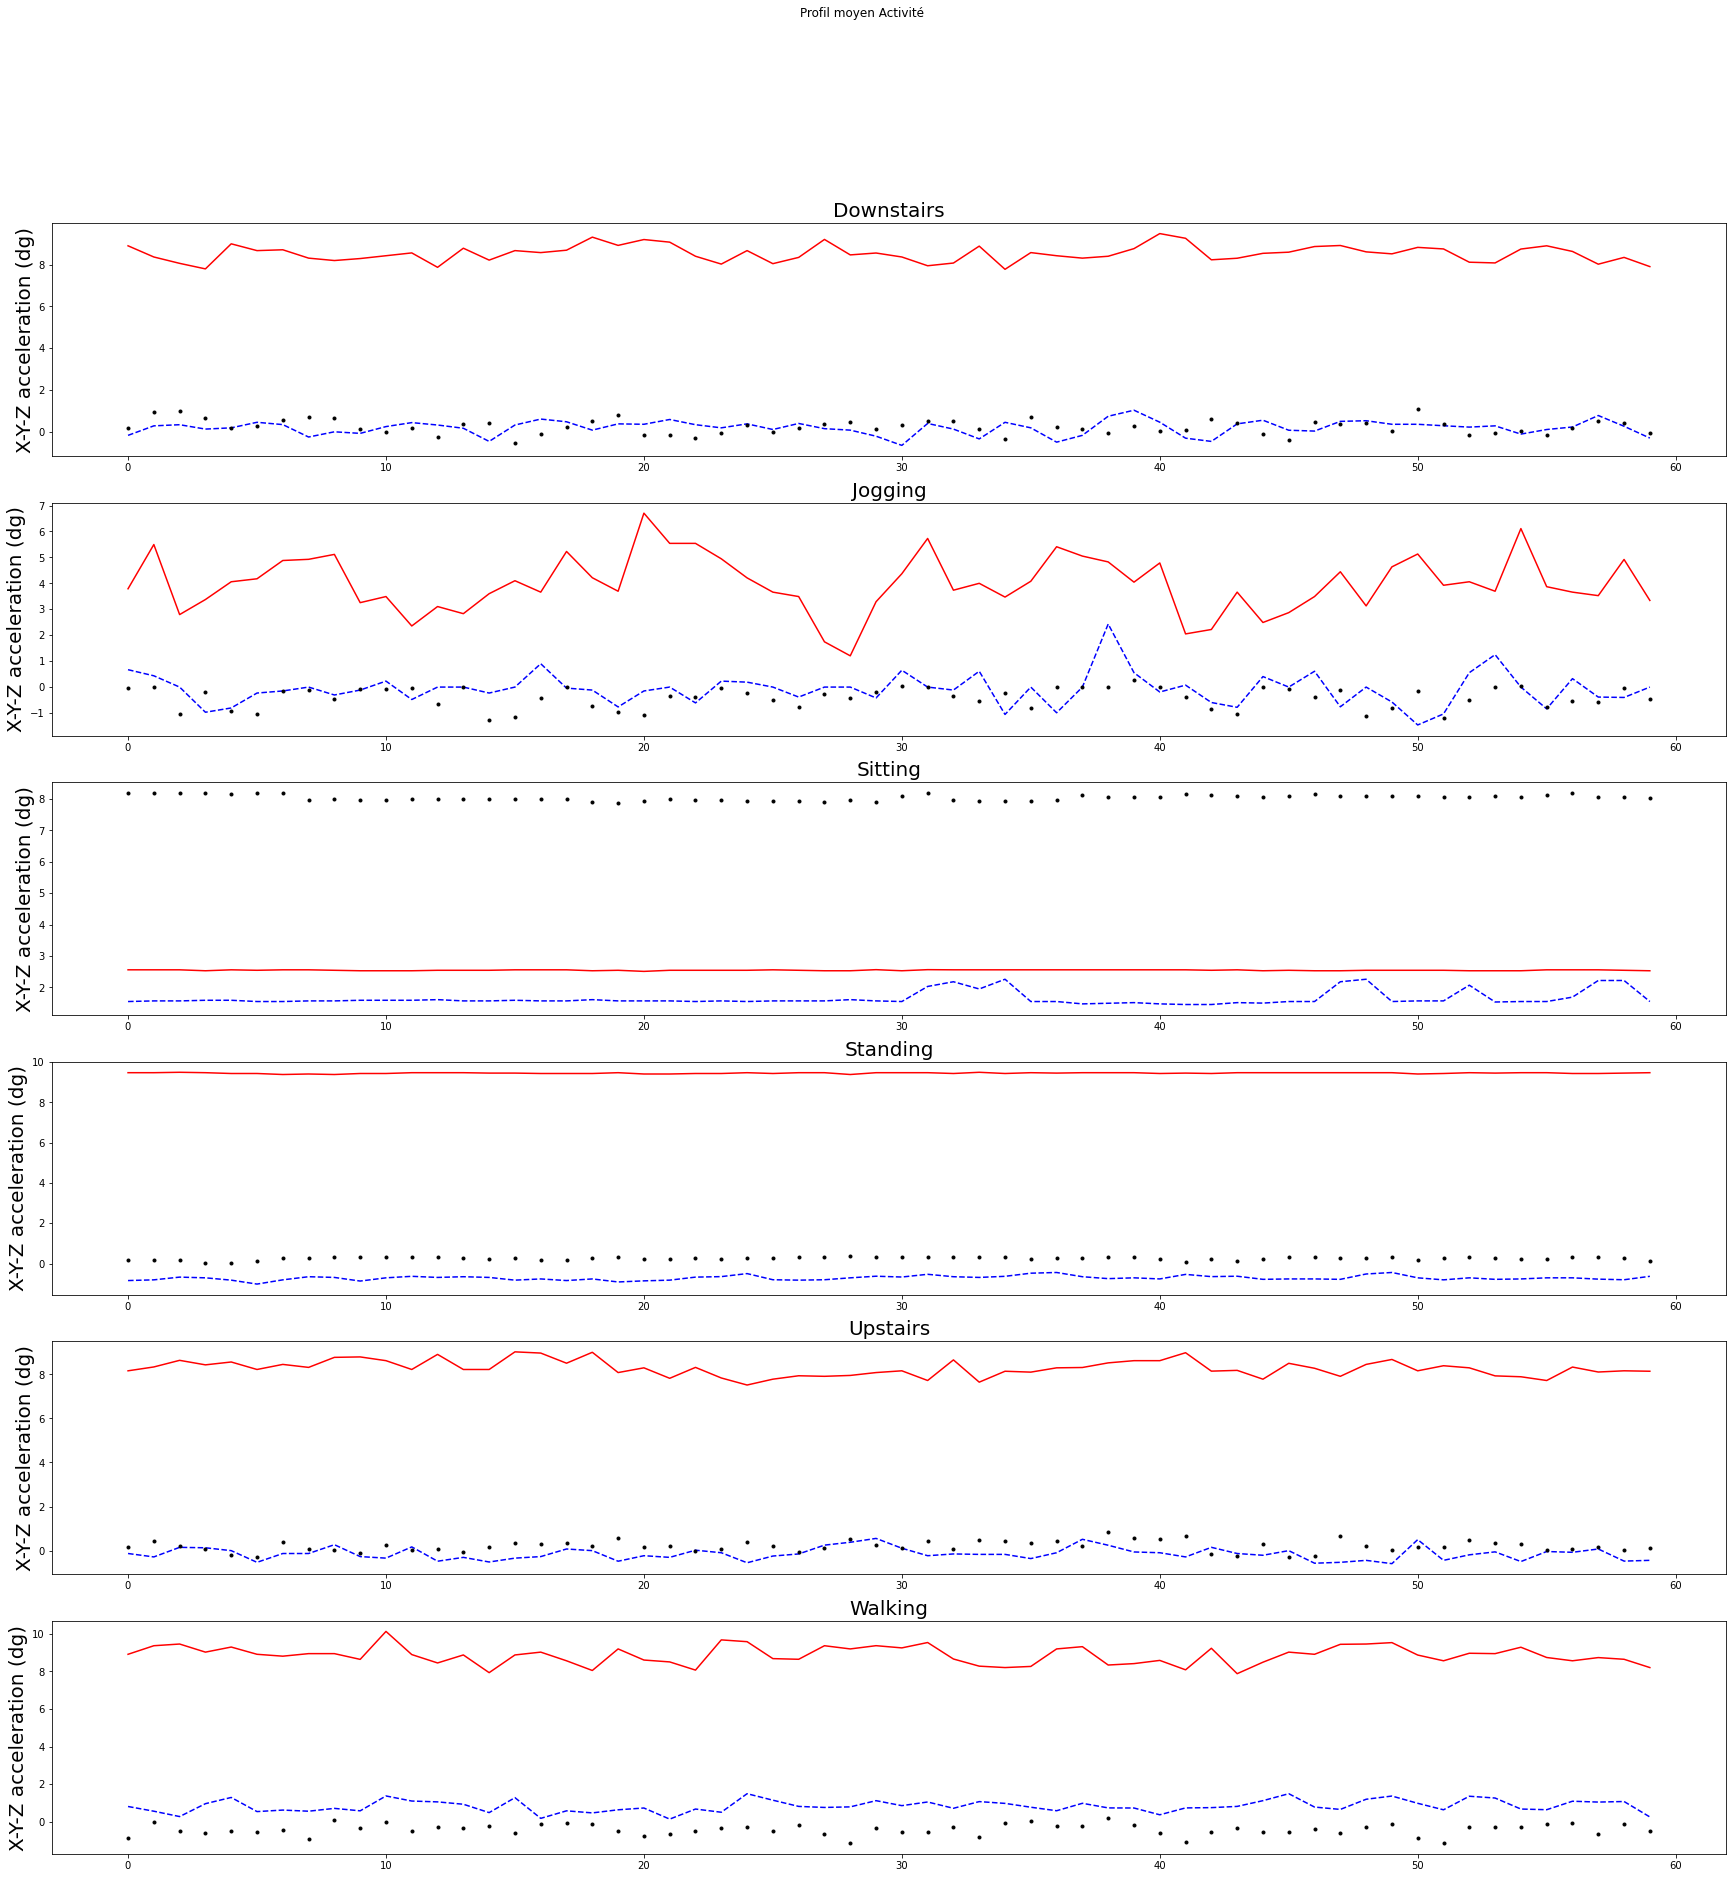

In [50]:
N_CLASSES = 6
SEGMENT_TIME_SIZE = 60 # <--

TAILLE_TEST = 100 # <--
TAILLE_APP  = 120 # <--

profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

On travaille avec taille test 100  number of classes :  6
(600, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.4716666666666667


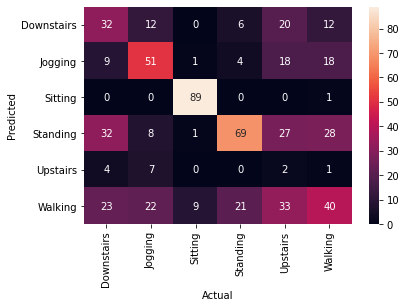

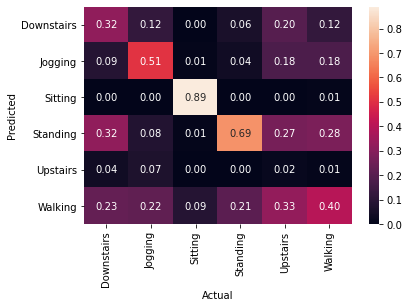

Accuracy per class :  [0.32 0.51 0.89 0.69 0.02 0.4 ]


In [51]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen, 1,1,1, 2) # <--
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.6533333333333333


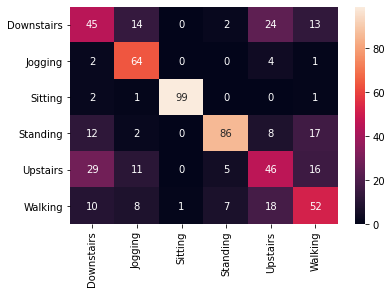

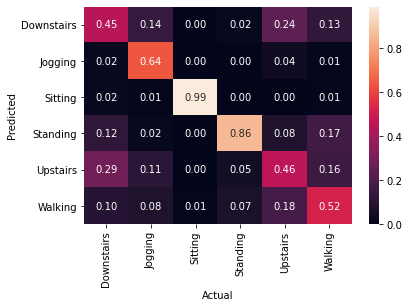

Accuracy per class :  [0.45 0.64 0.99 0.86 0.46 0.52]


In [52]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

## Without the last two classes Up and Walking



Convoluted data shape:  (9179, 60, 3)
Labels shape: (9179,)
(9179, 60, 3)
Classe N° 0
Classe N° 1
Classe N° 2
Classe N° 3
(480, 180)
(400, 180)


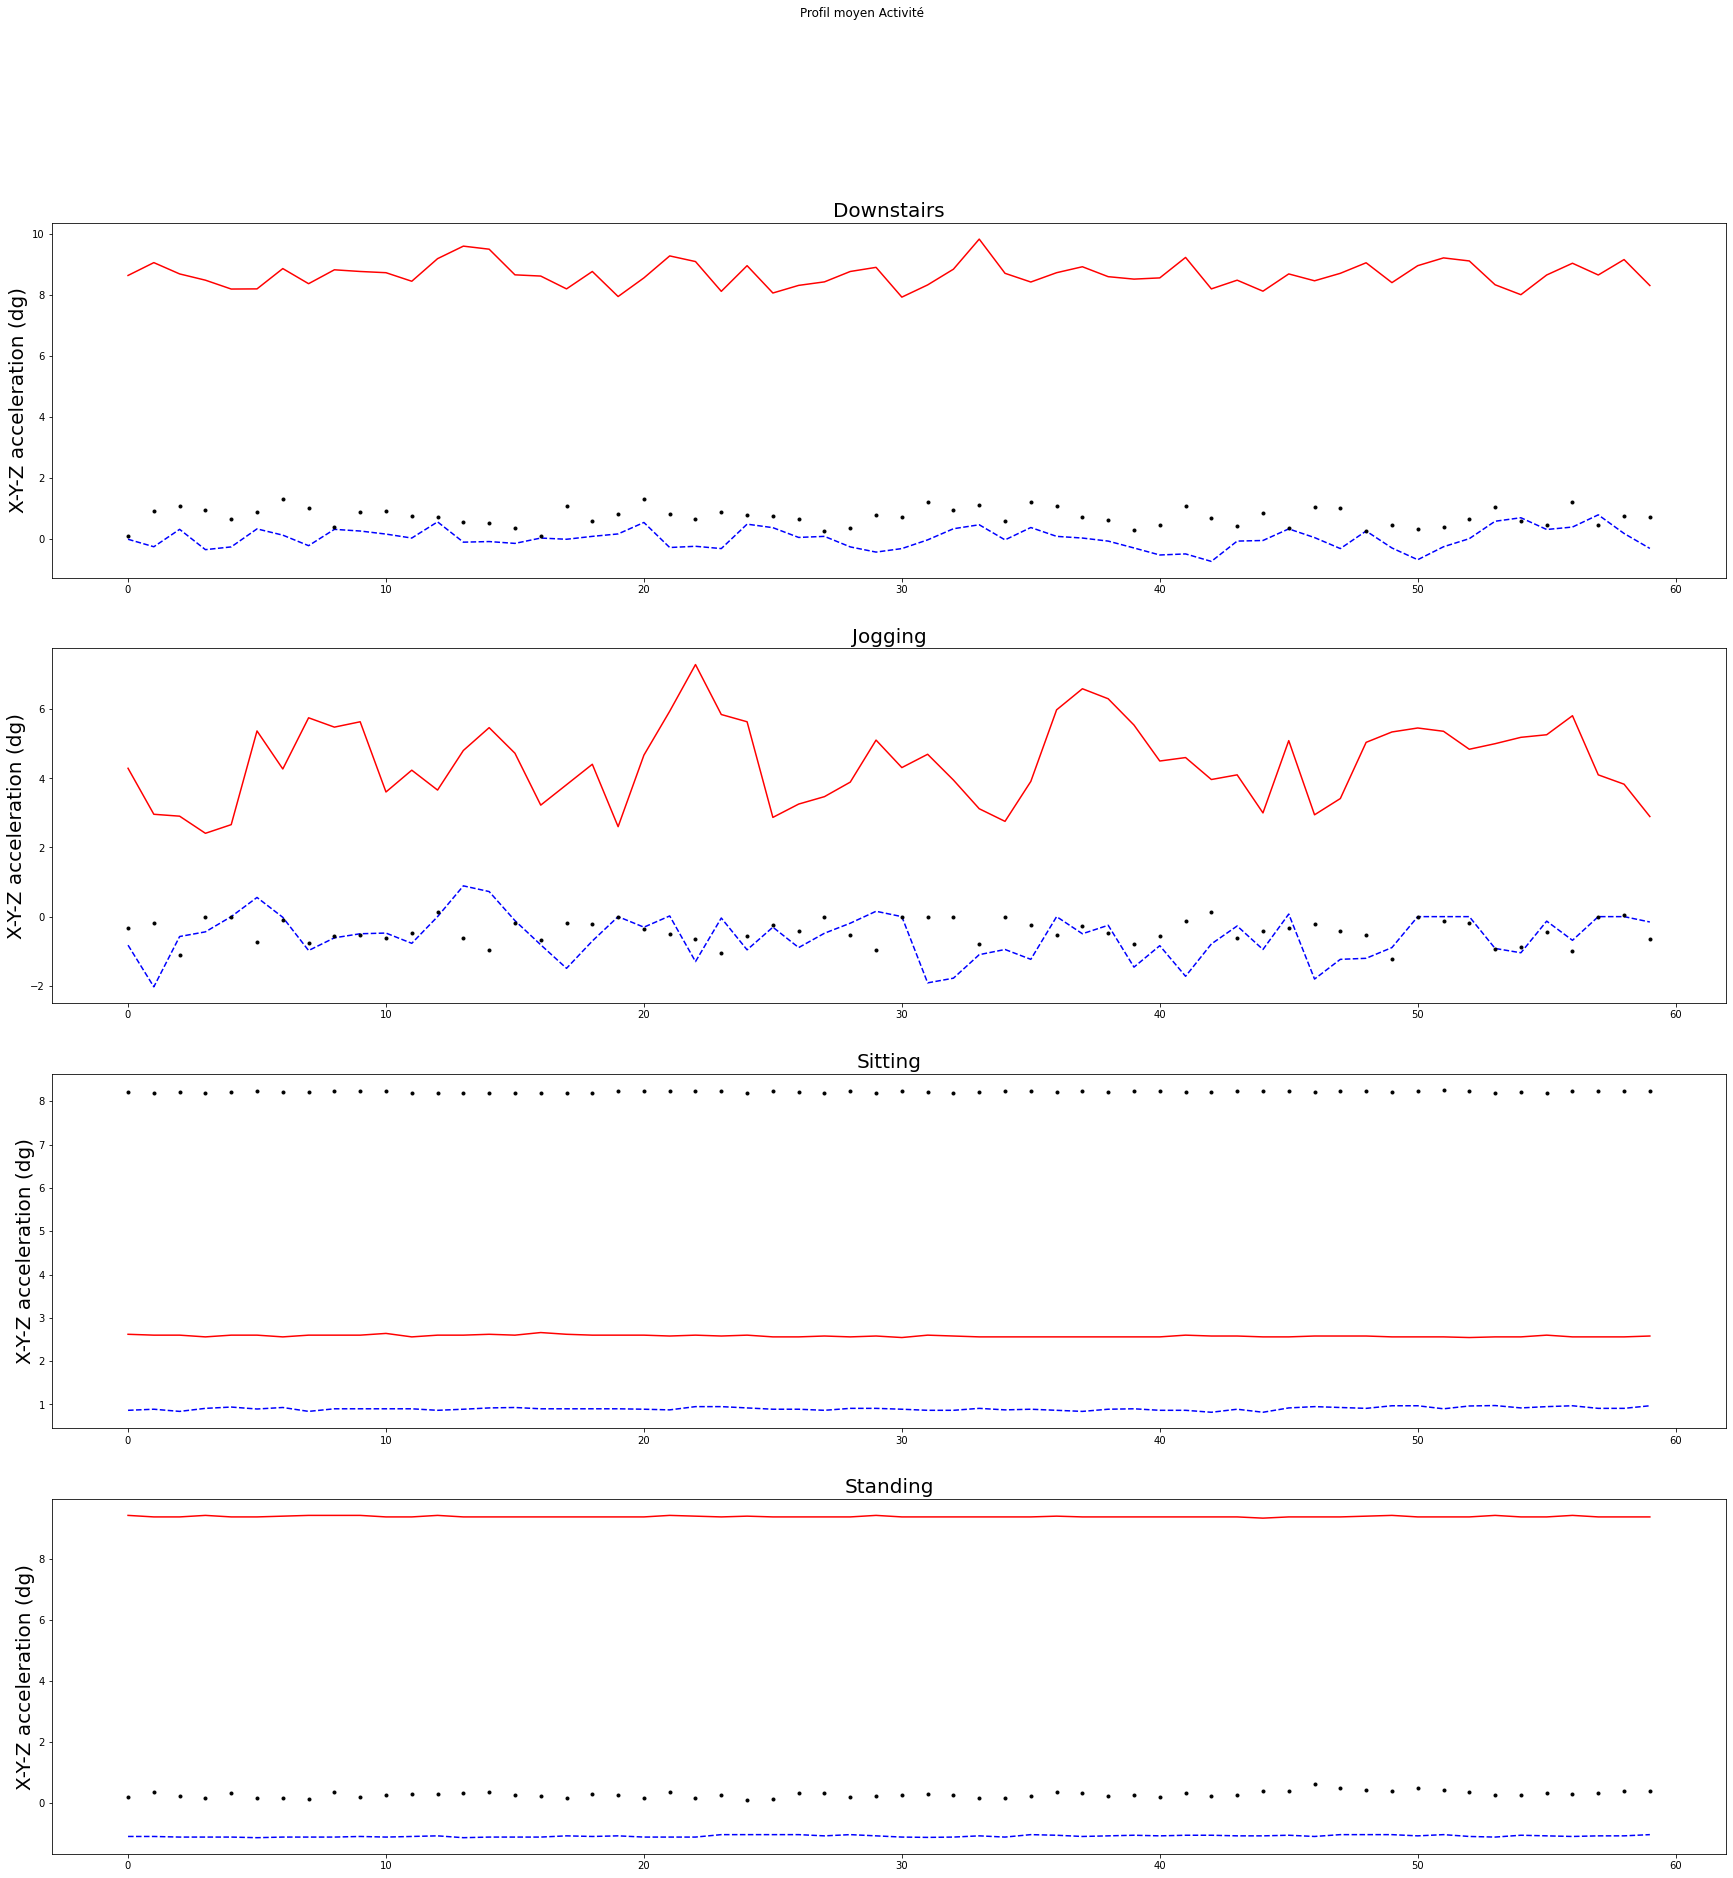

In [53]:
N_CLASSES = 4
SEGMENT_TIME_SIZE = 60 # <--

TAILLE_TEST = 100 # <--
TAILLE_APP  = 120 # <--

profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

On travaille avec taille test 100  number of classes :  4
(400, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.7225


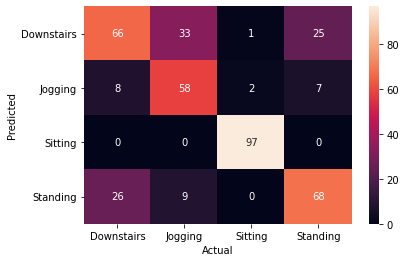

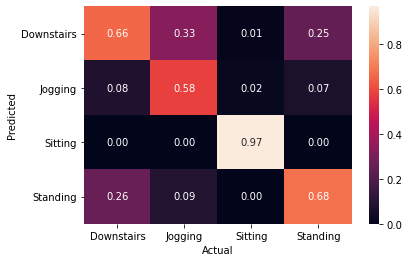

Accuracy per class :  [0.66 0.58 0.97 0.68]


In [54]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen, 1,1,1, 2) # <--
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.8775


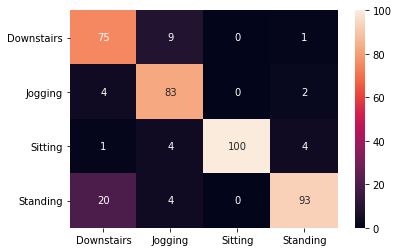

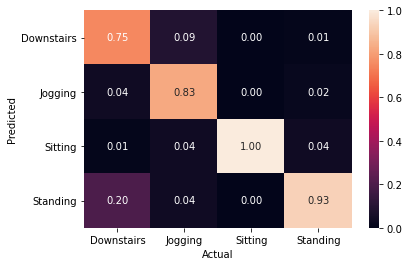

Accuracy per class :  [0.75 0.83 1.   0.93]


In [55]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

## Without Walking

Convoluted data shape:  (11226, 60, 3)
Labels shape: (11226,)
(11226, 60, 3)
Classe N° 0
Classe N° 1
Classe N° 2
Classe N° 3
Classe N° 4
(600, 180)
(500, 180)


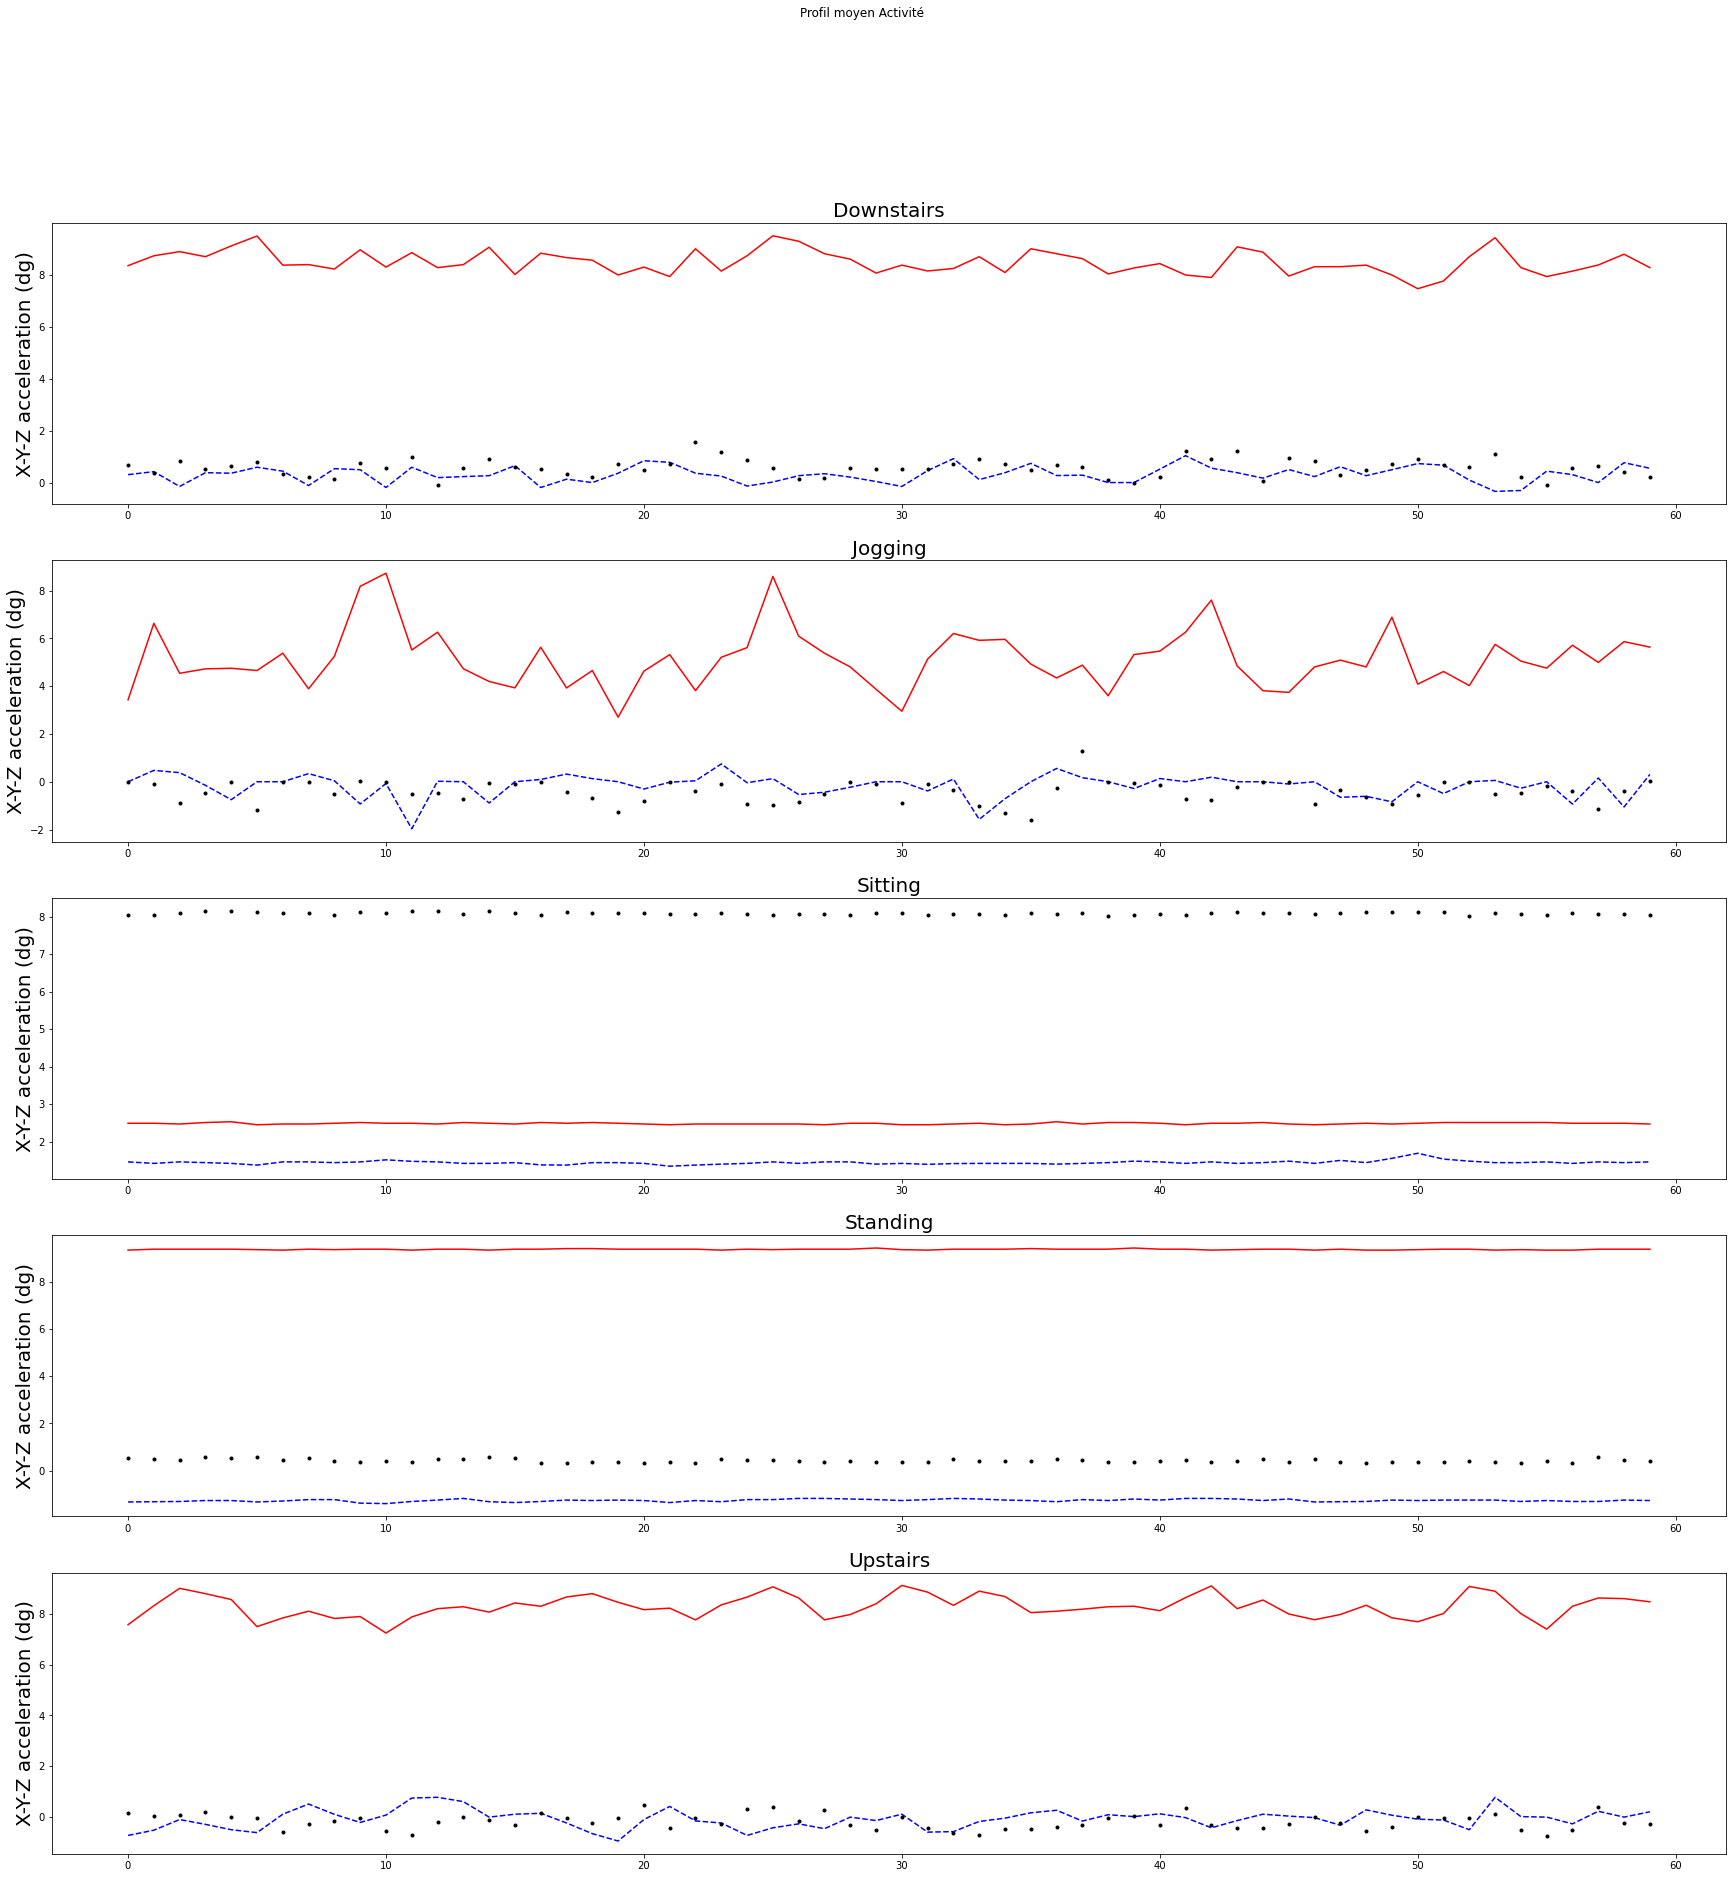

In [56]:
N_CLASSES = 5
SEGMENT_TIME_SIZE = 60 # <--

TAILLE_TEST = 100 # <--
TAILLE_APP  = 120 # <--

profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_test_Data=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)
data_convoluted,labels = get_data_convoluted(LABELS,SEGMENT_TIME_SIZE,TIME_STEP ,N_CLASSES)
spliting_data_Test_App(N_CLASSES,SEGMENT_TIME_SIZE,TAILLE_TEST, TAILLE_APP,List_Data_Test)

On travaille avec taille test 100  number of classes :  5
(500, 2)
Matrice de confusion par DTW
Accuracy sur base de test : 0.576


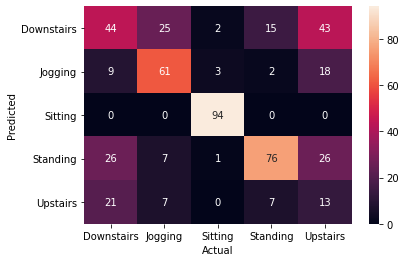

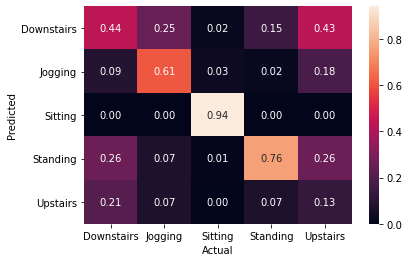

Accuracy per class :  [0.44 0.61 0.94 0.76 0.13]


In [57]:
PartitionDTW= np.zeros((TAILLE_TEST*N_CLASSES,2))
calcul_de_DTW(TAILLE_TEST,Label_Test , N_CLASSES , List_Data_Test , data_convoluted , profil_moyen, 1,1,1, 2) # <--
confusion_matrix_and_accuracy(PartitionDTW, LABELS, N_CLASSES)

Matrice de confusion avec ACP+kNN avec k = 1
Accuracy sur base de test : 0.772


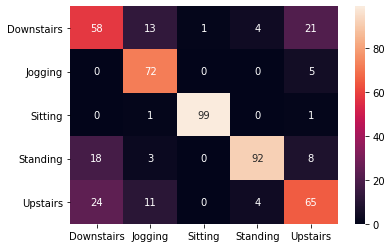

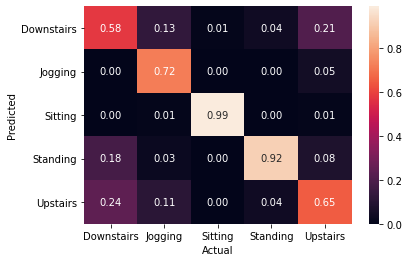

Accuracy per class :  [0.58 0.72 0.99 0.92 0.65]


In [58]:
n_components=5
# En implémentant l'ACP 
T=np.transpose(Data_App)
cov_mat=np.cov(np.transpose(Data_App))
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

KNN_result()

**on remarque qu'on a un contraste plus petit avec le PCA donc on conserve moins de données mais on a une meilleur précision**